https://www.kaggle.com/datasets/blastchar/telco-customer-churn

https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html

In [ ]:
!pip install catboost
!pip install shap
!pip install keras_tuner
!pip install scikit-plot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 3.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sns
from tqdm import tqdm
import re

from scipy import stats
from scipy.special import boxcox, inv_boxcox

from sklearn.model_selection import train_test_split

from sklearn.feature_selection import mutual_info_classif

import scikitplot as skplt

import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import _tree
from sklearn import tree

from sklearn.cluster import KMeans
from tqdm import tqdm
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
from yellowbrick.cluster import SilhouetteVisualizer

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import BernoulliNB
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from imblearn.pipeline import Pipeline as imbpipeline

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, roc_curve, precision_recall_curve
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import GridSearchCV

#from bayes_opt import BayesianOptimization

from sklearn import metrics

import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [ ]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

from sklearn.metrics import confusion_matrix
import itertools

import keras_tuner as kt
from keras_tuner import RandomSearch, HyperModel, BayesianOptimization, Hyperband
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow as tf

### Functions

In [ ]:
#########################
### Feature selection ###
#########################

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [ ]:
############################################
### Data sub populations from tree model ###
############################################

def get_rules(tree, feature_names, class_names, perc_thold = 80, sample_thold = 100):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []

    def recurse(node, path, paths):

        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]

    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]

    rules = []
    proba = []
    samples = []
    for path in paths:
        #print(path)
        rule = "if "

        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " then "
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" | based on {path[-1][1]:,} samples"

        if (np.round(100.0*classes[l]/np.sum(classes),2) > perc_thold) & (path[-1][1] > sample_thold):
            rules += [rule]
            proba += [np.round(100.0*classes[l]/np.sum(classes),2)]

    return rules, proba

In [ ]:
#############################
### New interaction terms ###
#############################

def new_f(new_name, name, var, cvar):
    X_train[new_name] = 0
    X_train.loc[X_train[cvar] == name, new_name] = X_train[var]
    X_test[new_name] = 0
    X_test.loc[X_test[cvar] == name, new_name] = X_test[var]

In [ ]:
#################################
### Variance inflation factor ###
#################################

def calculate_vif(features):
    vif = pd.DataFrame()
    vif["Features"] = features.columns
    vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
    return(vif)

In [ ]:
##############################
### Min-Max transformation ###
##############################

def minmax_dset(dset,numeric_columns):

    dseta = dset.copy()
    dsetb = pd.DataFrame(transformer_train.transform(dseta[numeric_columns]))
    dsetb.columns = numeric_columns
    print(dsetb.shape)
    return dsetb

In [ ]:
########################
### One hot encoding ###
########################

def ohe_dset(dset,categorical_columns):

    dseta = dset.copy()
    transformed_dset = ohe.fit_transform(dseta[categorical_columns])
    cat_data = pd.DataFrame(transformed_dset.toarray())
    cat_data.columns = ohe.get_feature_names_out(input_features=dseta[categorical_columns].columns)
    print(cat_data.shape)
    return cat_data

In [ ]:
#######################
### Model selection ###
#######################

def select_model(X, y, pipeline=None):
    """Test a range of classifiers and return their performance metrics on training data.

    Args:
        X (object): Pandas dataframe containing X_train data.
        y (object): Pandas dataframe containing y_train data.
        pipeline (object): Pipeline from get_pipeline().

    Return:
        df (object): Pandas dataframe containing model performance data.
    """

    classifiers = {}
    classifiers.update({"DummyClassifier": DummyClassifier(strategy='most_frequent')})
    classifiers.update({"LGBMClassifier": LGBMClassifier()})
    classifiers.update({"ExtraTreeClassifier": ExtraTreeClassifier()})
    classifiers.update({"RidgeClassifier": RidgeClassifier()})
    classifiers.update({"BernoulliNB": BernoulliNB()})
    classifiers.update({"SGDClassifier": SGDClassifier()})
    classifiers.update({"AdaBoostClassifier": AdaBoostClassifier()})
    classifiers.update({"CatBoostClassifier":CatBoostClassifier(silent=True)})
    classifiers.update({"XGBClassifier": XGBClassifier(use_label_encoder=False,
                                                       eval_metric='logloss',
                                                       objective='binary:logistic',
                                                     )})
    classifiers.update({"DecisionTreeClassifier": DecisionTreeClassifier()})

    # Stacking
    models = []

    # models = []
    # models.append(('XGBClassifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', objective='binary:logistic')))
    # models.append(('CatBoostClassifier', CatBoostClassifier(silent=True)))

    # classifiers.update({"VotingClassifier (XGBClassifier, CatBoostClassifier)": VotingClassifier(models)})

    # models = []
    # models.append(('XGBClassifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', objective='binary:logistic')))
    # models.append(('LGBMClassifier', LGBMClassifier()))
    # models.append(('CatBoostClassifier', CatBoostClassifier(silent=True)))
    # classifiers.update({"VotingClassifier (XGBClassifier, LGBMClassifier, CatBoostClassifier)": VotingClassifier(models)})

    # models = []
    # models.append(('XGBClassifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', objective='binary:logistic')))
    # models.append(('RandomForestClassifier', RandomForestClassifier()))
    # models.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
    # classifiers.update({"VotingClassifier (XGBClassifier, RandomForestClassifier, DecisionTreeClassifier)": VotingClassifier(models)})

    # models = []
    # models.append(('XGBClassifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', objective='binary:logistic')))
    # models.append(('AdaBoostClassifier', AdaBoostClassifier()))
    # models.append(('ExtraTreeClassifier', ExtraTreeClassifier()))
    # classifiers.update({"VotingClassifier (XGBClassifier, AdaBoostClassifier, ExtraTreeClassifier)": VotingClassifier(models)})

    # models = []
    # models.append(('XGBClassifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', objective='binary:logistic')))
    # models.append(('ExtraTreesClassifier', ExtraTreesClassifier()))
    # classifiers.update({"VotingClassifier (XGBClassifier, ExtraTreesClassifier)": VotingClassifier(models)})

    #scoring = {'f1_score' : make_scorer(f1_score, average='weighted')}

    df_models = pd.DataFrame(columns=['model', 'run_time', 'accuracy'])

    for key in tqdm(classifiers):
        start_time = time.time()
        #pipeline = get_pipeline(X, classifiers[key])

        pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), classifiers[key])

        cv = cross_val_score(pipeline, X, y, cv=5, scoring = 'roc_auc')
        row = {'model': key,
               'run_time': format(round((time.time() - start_time)/60,2)),
               'accuracy': cv.mean(),
        }
        row_df = pd.DataFrame(row, index=[0])

        df_models = pd.concat([df_models,
                                   row_df],
                                  axis=0,
                                  ignore_index=True)

        df_models = df_models.sort_values(by='accuracy', ascending=False)
    return df_models



In [ ]:
######################################
### Catboost Hyperparameter tuning ###
######################################

def CB_opt(n_estimators, depth, learning_rate, max_bin,
    subsample, num_leaves, l2_leaf_reg, model_size_reg):
    catb_scores = []
    skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1944)
    for train_index, test_index in skf.split(X_train_mod, y_train):

        trainx, valx = X_train_mod.iloc[train_index], X_train_mod.iloc[test_index]
        trainy, valy = pd.DataFrame(y_train).iloc[train_index], pd.DataFrame(y_train).iloc[test_index]

        reg = CatBoostClassifier(verbose = 0,
                               n_estimators = int(n_estimators),
                               learning_rate = learning_rate,
                               subsample = subsample,
                               l2_leaf_reg = l2_leaf_reg,
                               max_depth = int(depth),
                               num_leaves = int(num_leaves),
                               random_state = 88,
                               grow_policy = "Lossguide",
                               max_bin = int(max_bin),
                               use_best_model = True,
                               model_size_reg = model_size_reg,
                               eval_metric = 'AUC'

                               )

        reg.fit(trainx, trainy, eval_set = (valx, valy))
        catb_scores.append(roc_auc_score(valy, reg.predict(valx)))
    return np.mean(catb_scores)

In [ ]:
#################
### XGB Boost ###
#################

def xgbc_cv(max_depth,learning_rate,n_estimators,reg_alpha,reg_lambda,gamma):

    estimator_function = xgb.XGBClassifier(max_depth = int(max_depth),
                                               learning_rate = learning_rate,
                                               n_estimators = int(n_estimators),
                                               reg_alpha = reg_alpha,
                                               gamma = gamma,
                                               reg_lambda = reg_lambda,
                                               nthread = -1,
                                               objective = "binary:logistic",
                                               eval_metric = "auc",
                                               seed = seed)
    # Fit the estimator
    estimator_function.fit(X_train_mod, y_train)

    # calculate out-of-the-box roc_score using validation set 1
    probs = estimator_function.predict_proba(X_train_mod)
    probs = probs[:,1]
    val1_roc = roc_auc_score(y_train,probs)

    # calculate out-of-the-box roc_score using validation set 2
    probs = estimator_function.predict_proba(X_test)
    probs = probs[:,1]
    val2_roc = roc_auc_score(y_test,probs)

    # return the mean validation score to be maximized
    return np.array([val1_roc,val2_roc]).mean()

In [ ]:
##################
### LGBM model ###
##################

def lgb_eval(learning_rate,num_leaves, feature_fraction, bagging_fraction, max_depth, max_bin, min_data_in_leaf,min_sum_hessian_in_leaf,subsample):

    params = {'application':'binary', 'metric':'auc'}
    params['learning_rate'] = max(min(learning_rate, 1), 0)
    params["num_leaves"] = int(round(num_leaves))
    params['feature_fraction'] = max(min(feature_fraction, 1), 0)
    params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
    params['max_depth'] = int(round(max_depth))
    params['max_bin'] = int(round(max_depth))
    params['min_data_in_leaf'] = int(round(min_data_in_leaf))
    params['min_sum_hessian_in_leaf'] = min_sum_hessian_in_leaf
    params['subsample'] = max(min(subsample, 1), 0)

    cv_result = lgb.cv(params,
                           train_data,
                           nfold = 10,
                           seed = 6,
                           stratified = True,
                           verbose_eval = 200,
                           metrics = ['auc'])
    return max(cv_result['auc-mean'])

In [ ]:
########################
### Confusion matrix ###
########################

def cm2df(cm, labels):
            df = pd.DataFrame()

            for i, row_label in enumerate(labels):
                rowdata={}

                for j, col_label in enumerate(labels):
                    rowdata[col_label]=cm[i,j]
                df = df.append(pd.DataFrame.from_dict({row_label:rowdata}, orient='index'))
            return df[labels]

In [ ]:
#########################
### Compare box plots ###
#########################

def boxplot_compare(target, var, num):
    fig, ax=plt.subplots(1, 2, figsize=(20, 7))
    d1 = df[df[target] == 'Yes']
    d1 = d1.sort_values([var])
    d2 = df[df[target] == 'No']
    d2 = d2.sort_values([var])
    g1 = sns.boxplot(data=d1, x=num, y=var, palette='rainbow', showmeans=True, ax=ax[0])
    g1.set_title("Churn Data")
    g1.set_xlim(0, max(df[num]) + 10)

    g2 = sns.boxplot(data=d2, x=num, y=var, palette='rainbow', showmeans=True, ax=ax[1])
    g2.set(ylabel=None)
    g2.set(yticklabels=[])
    g2.set_title("Non Churn Data")
    g2.set_xlim(0, max(df[num]) + 10)
    plt.show();

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    #plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
class ClfHyperModel(kt.HyperModel):

    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = Sequential()

        model.add(
            Dense(
                units=hp.Int('units', 8, 32, 4, default=8),
                activation=hp.Choice(
                    'dense_activation',
                    values=['relu', 'tanh','softmax'],
                    default='relu'),
                input_shape=input_shape
            )
        )

        model.add(
            Dropout(
                hp.Float(
                    'dropout',
                    min_value=0.0,
                    max_value=0.3,
                    default=0.0,
                    step=0.05)
            )
        )
        #model.add(Dense(1, activation='sigmoid'))
        model.add(Dense(1, activation='linear'))

        hp_learning_rate = hp.Choice('learning_rate',
                                 values=[1e-2, 1e-3, 1e-4]
                                 )
        optimizers_dict = {
            "Adam":    Adam(learning_rate=hp_learning_rate),
            "SGD":     SGD(learning_rate=hp_learning_rate),
            }

        hp_optimizers = hp.Choice(
            'optimizer',
            values=["Adam", "SGD"]
            )


        model.compile(optimizer=optimizers_dict[hp_optimizers], loss = 'binary_crossentropy', metrics=[tf.keras.metrics.AUC()])
        #model.compile(optimizer=optimizers_dict[hp_optimizers], loss = BinaryCrossEntropy(from_logits = True), metrics=[tf.keras.metrics.AUC()]) # multiclass

        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [16, 32, 64, 128]),
            **kwargs,
        )

In [ ]:
def diag_vals(model):

  model_predictions = model.predict(X_test, batch_size=100, verbose=0)
  y_pred = np.argmax(model_predictions, axis=1)

  roc_auc = roc_auc_score(y_test, y_pred)
  accuracy = accuracy_score(y_test, y_pred)
  f1_score = metrics.f1_score(y_test, y_pred)

  print('ROC/AUC:', roc_auc)
  print('Accuracy:', accuracy)
  print('F1 score:', f1_score)

  o_threshold = 0.5

  if roc_auc == 0.5:

    fpr, tpr, thresholds = roc_curve(y_train, model.predict(X_train_mod), drop_intermediate=False)
    plt.scatter(thresholds,np.abs(fpr+tpr-1))
    plt.xlabel("Threshold")
    plt.ylabel("|FPR + TPR - 1|")
    plt.xlim([0.0, 1.05])
    plt.ylim([0.0, 1.05])
    plt.show()

    o_threshold = thresholds[np.argmin(np.abs(fpr+tpr-1))]
    print('Threshold:', o_threshold)

    model.predict(X_test)
    y_pred_o = (model.predict(X_test) >= o_threshold)[:,0]

    confusion_matrix_o = confusion_matrix(y_test, y_pred_o)
    plt.figure(figsize = (12,8))
    sns.set(font_scale=1.4)
    ax = sns.heatmap(confusion_matrix_o, cmap='Blues',annot=True, fmt='d', square=True,xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    ax.set(xlabel='Predicted', ylabel='Actual')
    ax.invert_yaxis()
    ax.invert_xaxis()

    roc_auc = roc_auc_score(y_test, y_pred_o)
    accuracy = accuracy_score(y_test, y_pred_o)
    f1_score = metrics.f1_score(y_test, y_pred_o)

    print('ROC/AUC threshold:', roc_auc)
    print('Accuracy threshold:', accuracy)
    print('F1 score threshold:', f1_score)

  return roc_auc, accuracy, f1_score, o_threshold

### Read in the data

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
# Change directory
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/Telco Customer Churn")
# Print out the current directory
!pwd

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/Telco Customer Churn


In [ ]:
data = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
print(data.shape)
data.head()

(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
data.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [ ]:
print(list(data.columns))

['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']


In [ ]:
nonvar_lst = []

for i in range(data.shape[1]):
    print('Column: ', data.columns[i], ', number of unique classes: ', data.iloc[:,i].nunique())
    if data.iloc[:,i].nunique() < 50:
        print('Values: ', list(set(data.iloc[:,i])))
    if data.iloc[:,i].nunique() == 1:
        nonvar_lst.append(data.columns[i])



Column:  customerID , number of unique classes:  7043
Column:  gender , number of unique classes:  2
Values:  ['Female', 'Male']
Column:  SeniorCitizen , number of unique classes:  2
Values:  [0, 1]
Column:  Partner , number of unique classes:  2
Values:  ['Yes', 'No']
Column:  Dependents , number of unique classes:  2
Values:  ['Yes', 'No']
Column:  tenure , number of unique classes:  73
Column:  PhoneService , number of unique classes:  2
Values:  ['Yes', 'No']
Column:  MultipleLines , number of unique classes:  3
Values:  ['Yes', 'No', 'No phone service']
Column:  InternetService , number of unique classes:  3
Values:  ['No', 'DSL', 'Fiber optic']
Column:  OnlineSecurity , number of unique classes:  3
Values:  ['Yes', 'No', 'No internet service']
Column:  OnlineBackup , number of unique classes:  3
Values:  ['Yes', 'No', 'No internet service']
Column:  DeviceProtection , number of unique classes:  3
Values:  ['Yes', 'No', 'No internet service']
Column:  TechSupport , number of uniqu

In [ ]:
print(nonvar_lst)

[]


### Missing data

In [ ]:
check = data.isnull().sum()
check = pd.DataFrame(check)
check.columns = ['Count']
check['perc'] = check.Count/data.shape[0]*100
check

,Count,perc
customerID,0,0.0
gender,0,0.0
SeniorCitizen,0,0.0
Partner,0,0.0
Dependents,0,0.0
tenure,0,0.0
PhoneService,0,0.0
MultipleLines,0,0.0
InternetService,0,0.0
OnlineSecurity,0,0.0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


### Target variable

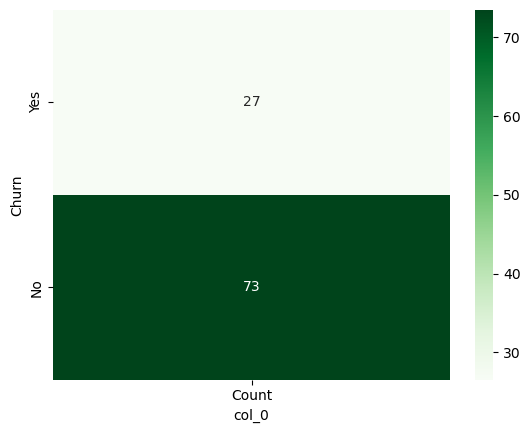

In [ ]:
target_t = pd.DataFrame(pd.crosstab(data.Churn, columns = 'Count', normalize='columns'))
target_t = target_t * 100

ax = sns.heatmap(target_t, annot = True, cmap="Greens")
ax.invert_yaxis()

In [ ]:
print('No churn', round(data['Churn'].value_counts()[0]/len(data) * 100,2), '% of the dataset')
print('Churn', round(data['Churn'].value_counts()[1]/len(data) * 100,2), '% of the dataset')

No churn 73.46 % of the dataset
Churn 26.54 % of the dataset


### Adjust the training set

In [ ]:
data = data.drop_duplicates()
print(data.shape)

(7043, 21)


In [ ]:
pd.crosstab(data.TotalCharges, columns = 'Count')
pd.crosstab(data.TotalCharges == ' ', columns = 'Count')

col_0,Count
TotalCharges,
False,7032
True,11


In [ ]:
df = data.copy()

df = df[df.TotalCharges != ' ']

for name in ['Partner','Dependents','PhoneService','PaperlessBilling','Churn']:
    df[name + '_n'] = (df[name] == 'Yes').astype(int)

df['gender_n'] = (df['gender'] == 'Male').astype(int)

df.rename(columns={"SeniorCitizen": "SeniorCitizen_n"}, inplace = True)

for name in ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
             'Contract', 'PaymentMethod']:

    data[name] = data[name].str.replace('-','_')
    data[name] = data[name].str.replace(' ','_')
    data[name] = data[name].str.replace('(','')
    data[name] = data[name].str.replace(')','')

df.TotalCharges = df.TotalCharges.astype(float)

print(df.shape)
df.head()

(7032, 27)


<ipython-input-11-c9f09f753431>:17: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data[name] = data[name].str.replace('(','')
<ipython-input-11-c9f09f753431>:18: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data[name] = data[name].str.replace(')','')


,customerID,gender,SeniorCitizen_n,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Partner_n,Dependents_n,PhoneService_n,PaperlessBilling_n,Churn_n,gender_n
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,Electronic check,29.85,29.85,No,1,0,0,1,0,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Mailed check,56.95,1889.50,No,0,0,1,0,0,1
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,Mailed check,53.85,108.15,Yes,0,0,1,1,1,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Bank transfer (automatic),42.30,1840.75,No,0,0,0,0,0,1
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,Electronic check,70.70,151.65,Yes,0,0,1,1,1,0


### Numerical data

In [ ]:
print([col for col in df.columns if '_n' in col])

['SeniorCitizen_n', 'gender_n', 'Partner_n', 'Dependents_n', 'PhoneService_n', 'PaperlessBilling_n', 'Churn_n']


In [ ]:
num_cols = list(df.select_dtypes(include=['number'], exclude=['datetime', 'timedelta']).columns)
num_cols = (list(set(num_cols) - set([col for col in df.columns if '_n' in col])))
print(num_cols)

['tenure', 'TotalCharges', 'MonthlyCharges']


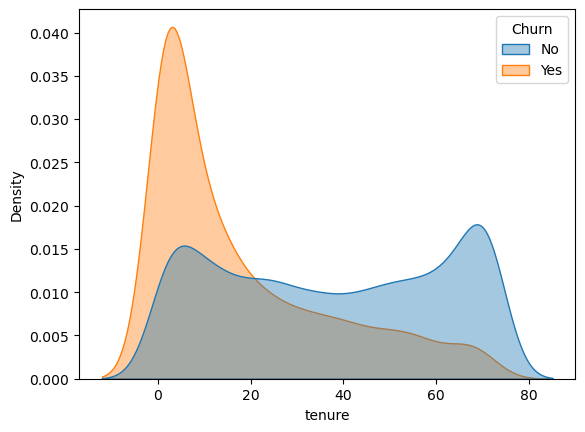

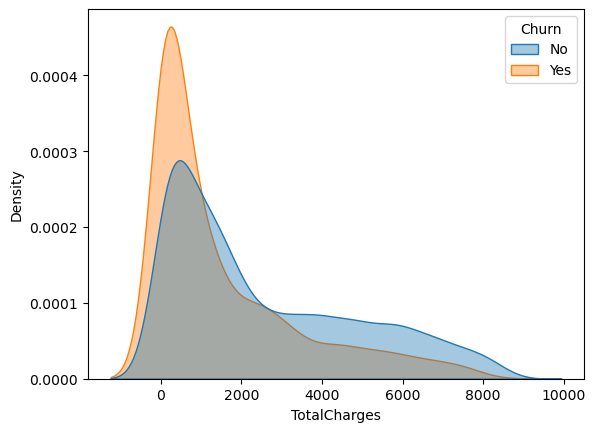

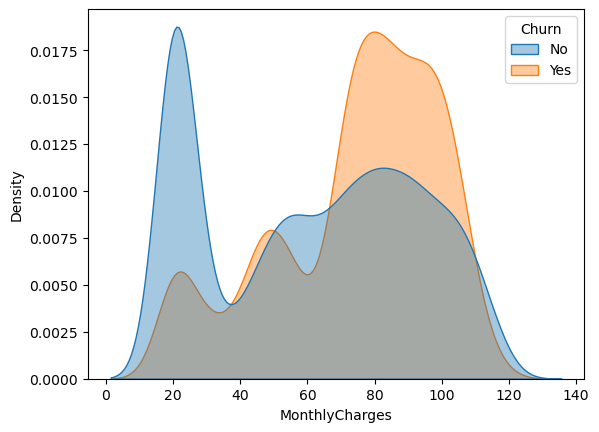

In [ ]:
for name in num_cols:
    sns.kdeplot(data=df, x=name, hue="Churn", fill=True, common_norm=False, alpha=0.4)
    plt.show()

### Interaction terms

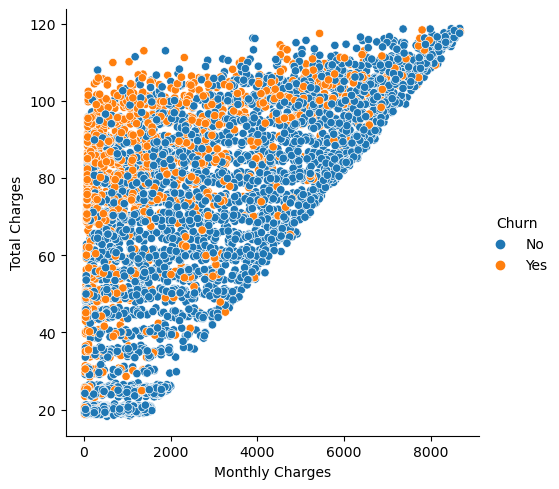

In [ ]:
sns.relplot(x='TotalCharges',
            y='MonthlyCharges',
            data = df,
            kind='scatter',
            hue='Churn')
plt.ylabel("Total Charges")
plt.xlabel("Monthly Charges")
plt.show();

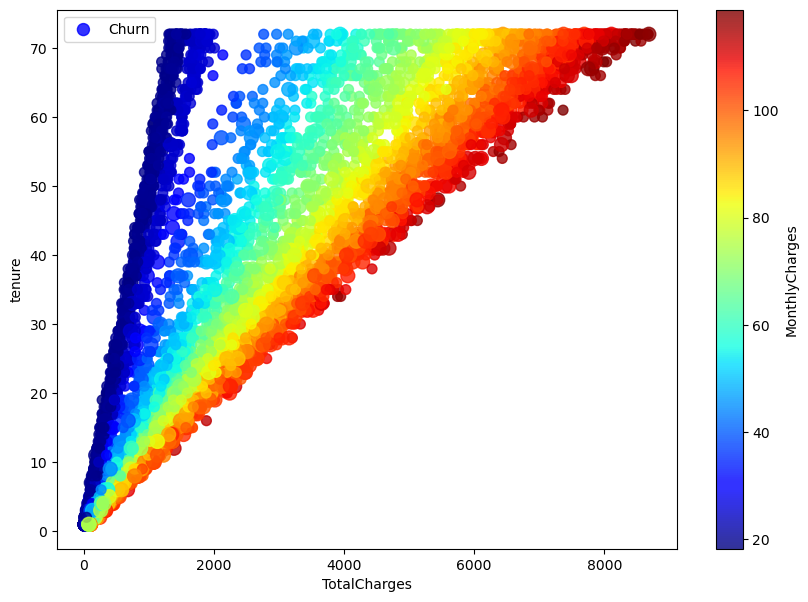

In [ ]:
data_v = df.copy()
data_v["Churn_n"] = (data_v["Churn_n"] + 1) * 50
data_v["Churn_n"] = data_v["Churn_n"].astype(int)

data_v.plot(kind="scatter", x="TotalCharges", y="tenure", alpha=0.8,
             s=data_v["Churn_n"], label="Churn", figsize=(10,7),
             c="MonthlyCharges", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)
plt.legend()
plt.show();

In [ ]:
# Contract              0.096910
# tenure                0.083345
# OnlineSecurity        0.063449
# TechSupport           0.061518
# InternetService       0.052963
# MonthlyCharges        0.049854
# PaymentMethod         0.048688
# OnlineBackup          0.046357

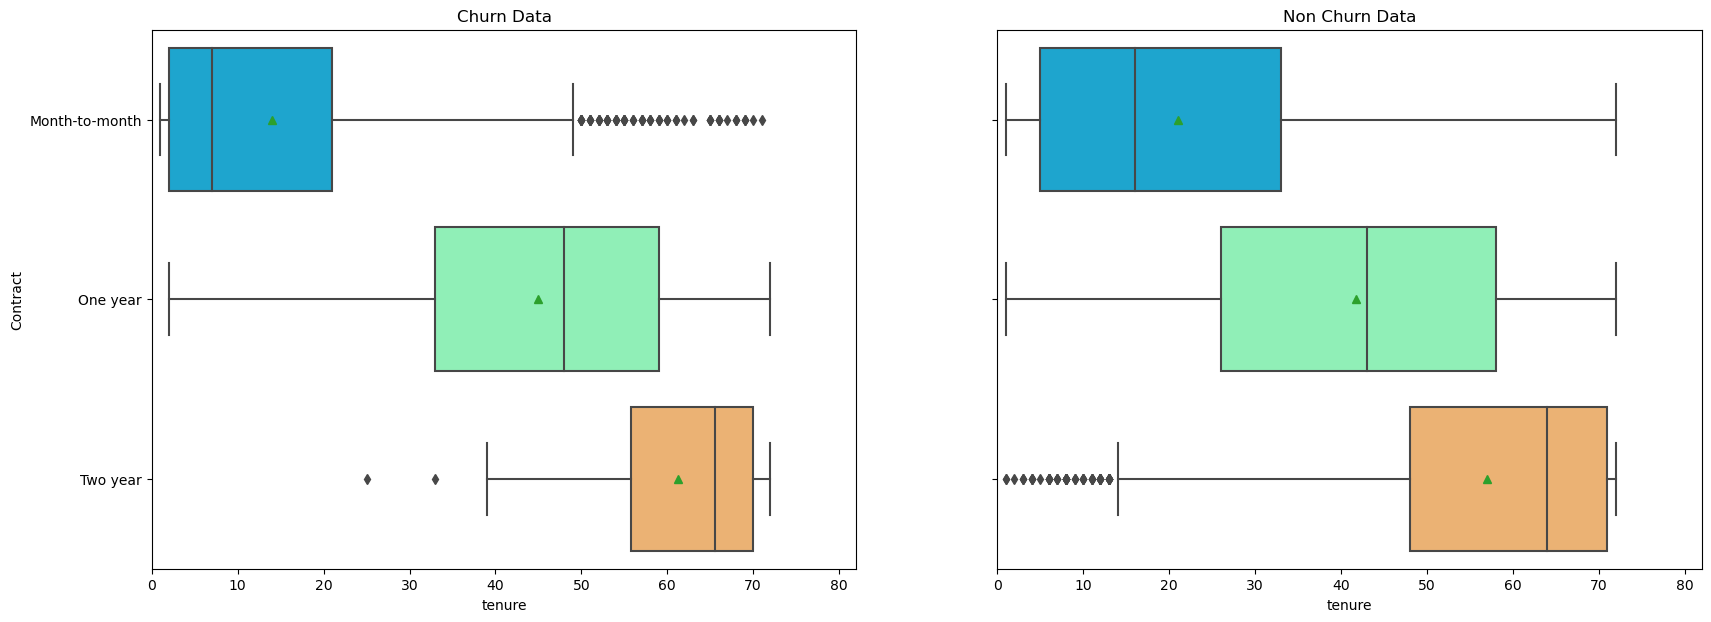

In [ ]:
boxplot_compare('Churn', "Contract", "tenure")

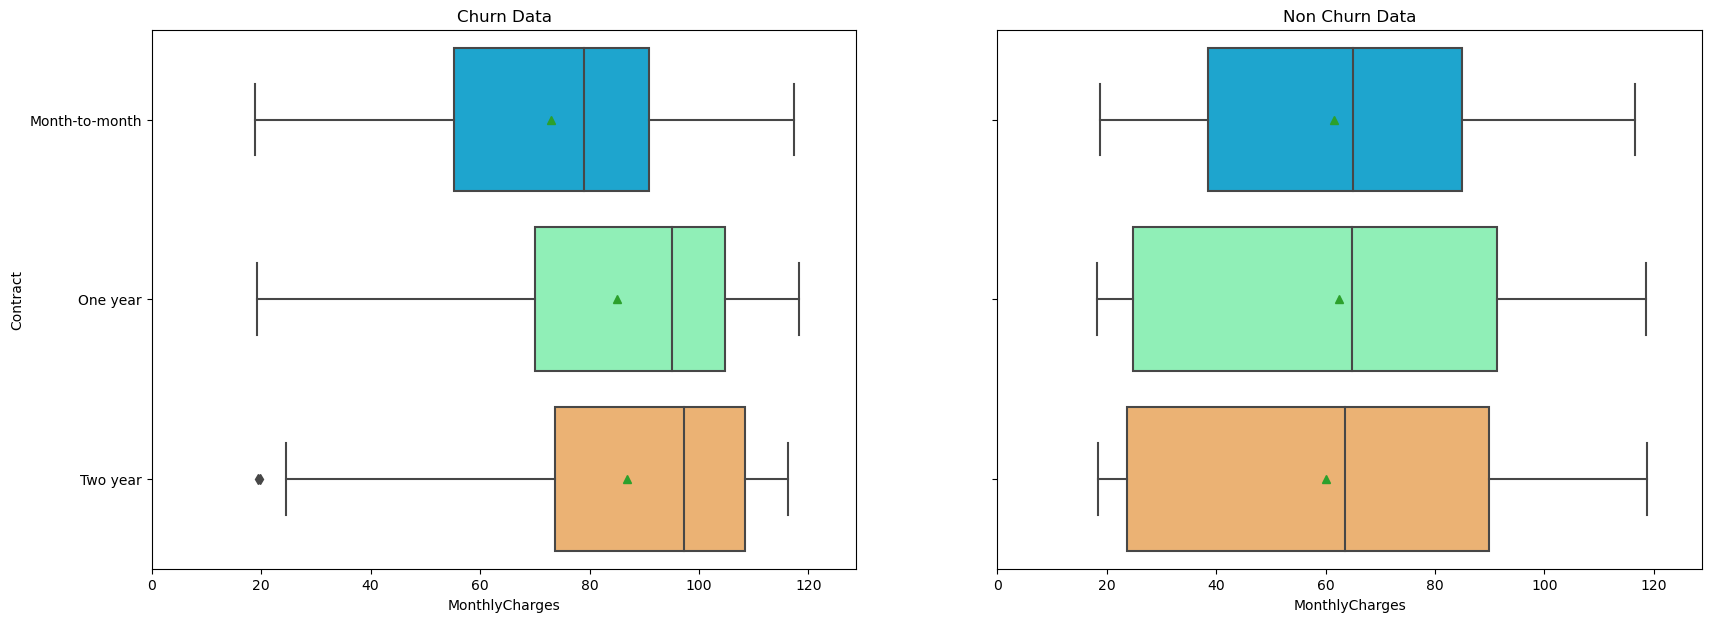

In [ ]:
boxplot_compare('Churn', "Contract", "MonthlyCharges")

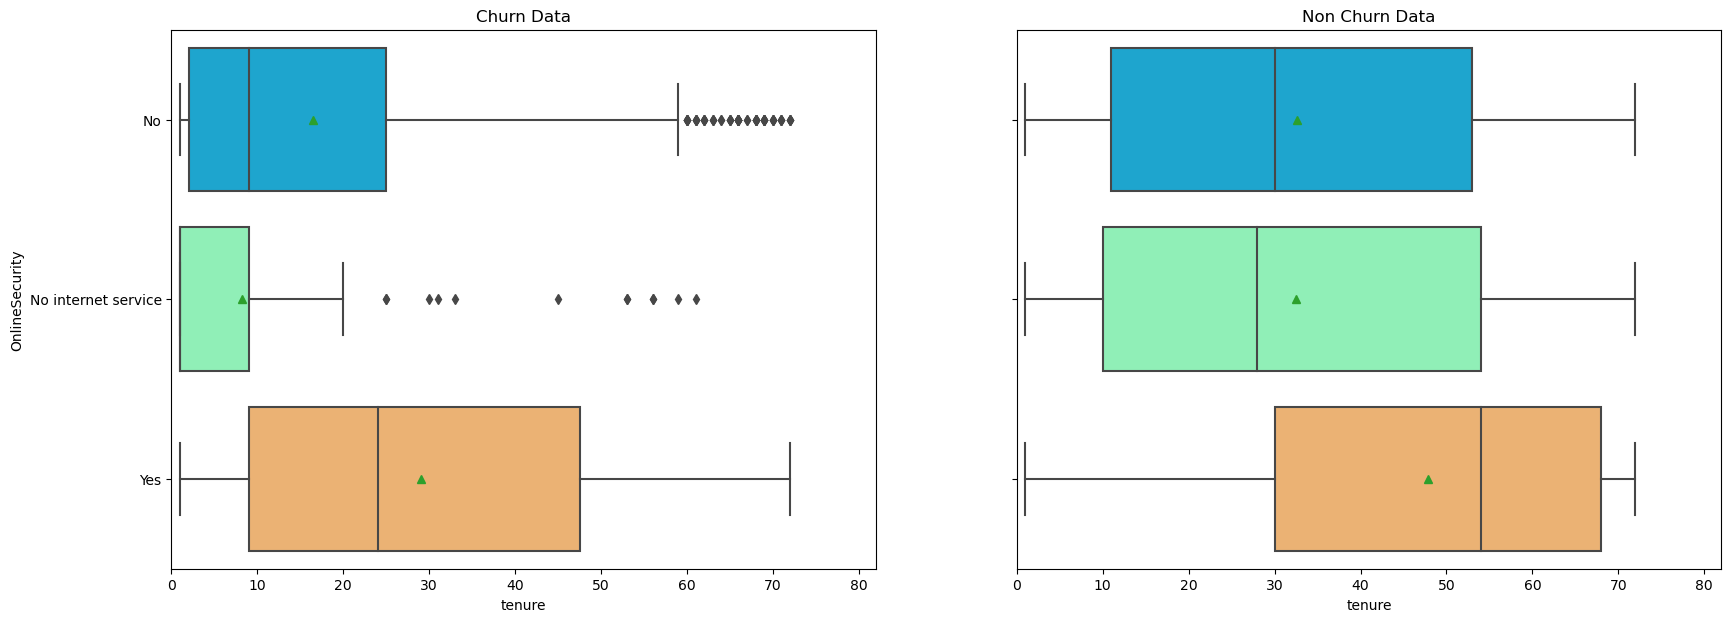

In [ ]:
boxplot_compare('Churn', "OnlineSecurity", "tenure")

### Categorial data

In [ ]:
cat_cols = list(df.select_dtypes(include=['object']))
cat_cols.remove('customerID')
cat_cols.remove('Churn')
print(cat_cols)

['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


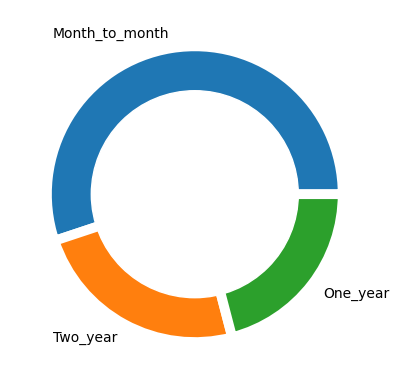

In [ ]:
name = 'Contract'
c_loc = df.sort_values(by = name)
c_loc = c_loc.groupby([name])['Churn'].count().reset_index()
c_loc['perc'] = c_loc['Churn']/df.shape[0] * 100
c_loc = c_loc.sort_values(by = 'perc', ascending = False)
c_loc['cum_perc'] = c_loc['perc'].cumsum()
c_loc = c_loc.reset_index(drop=True)

my_circle = plt.Circle( (0,0), 0.7, color='white')

plt.pie(c_loc.perc, labels=c_loc[name], wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.


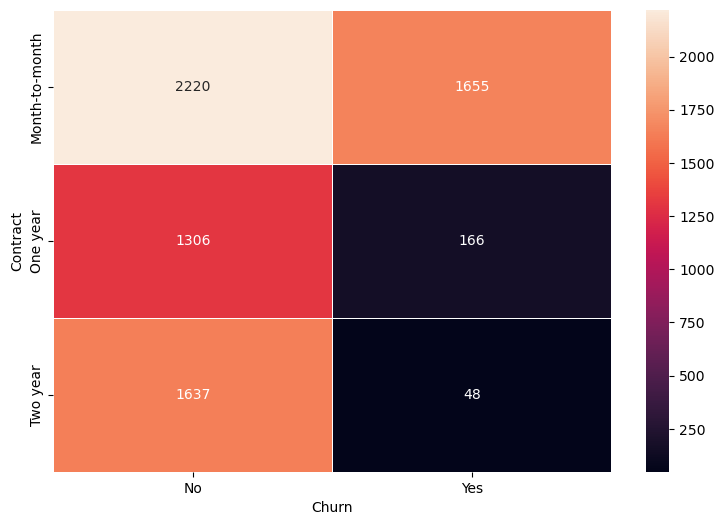

In [ ]:
data_a = df.groupby(['Contract','Churn']).size().reset_index()
data_a.columns = ['Contract','Churn','Count']
data_a = data_a.pivot('Contract','Churn','Count')

for i in range(data_a.shape[1]):
    data_a.iloc[:,i] = data_a.iloc[:,i].fillna(0)
    data_a.iloc[:,i] = data_a.iloc[:,i].astype(int)

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data_a, annot=True, fmt="d", linewidths=.5, ax=ax)
plt.show();

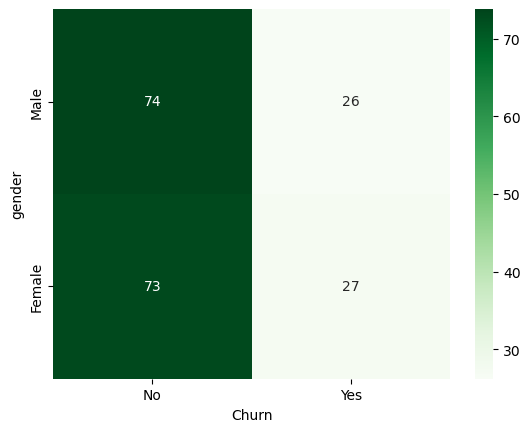

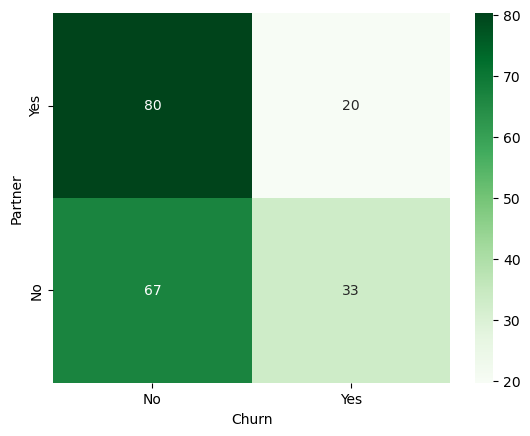

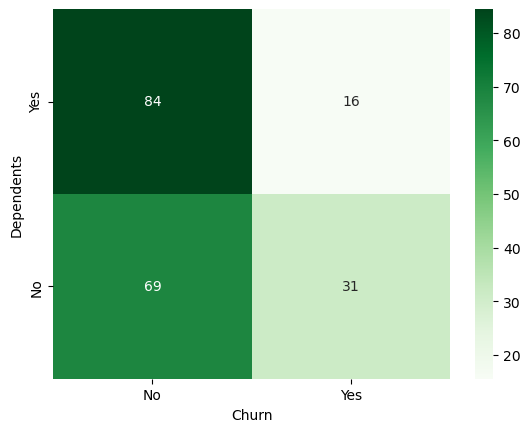

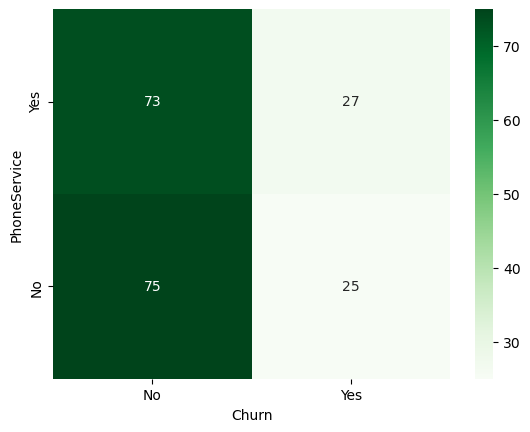

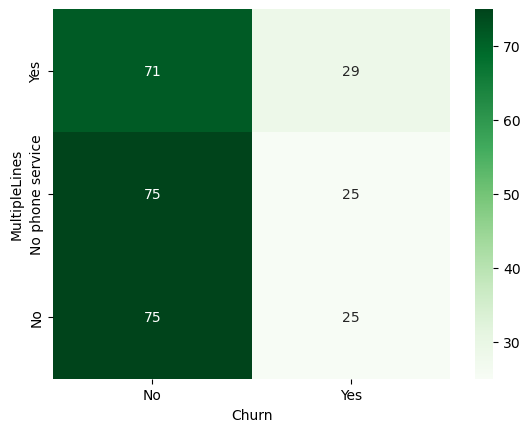

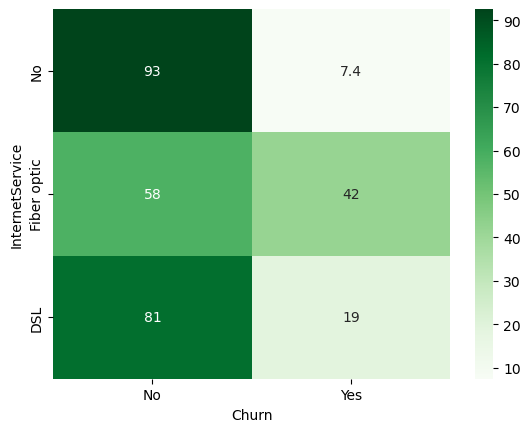

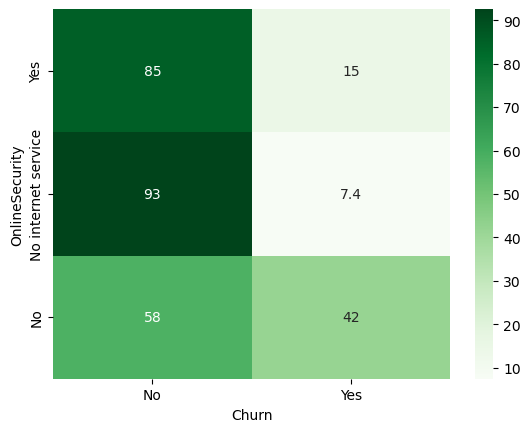

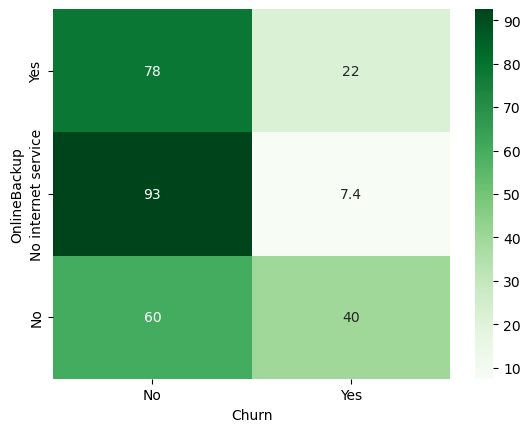

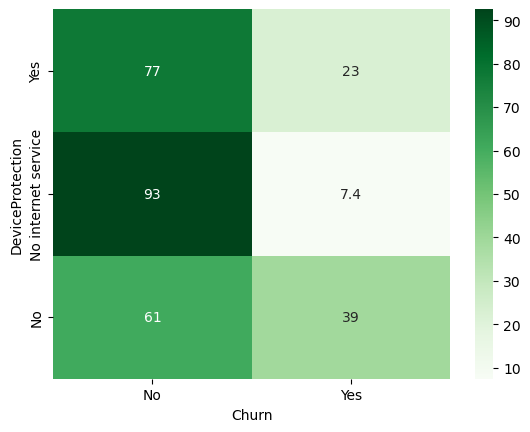

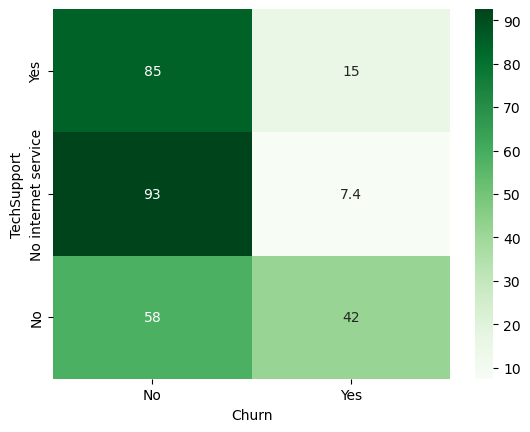

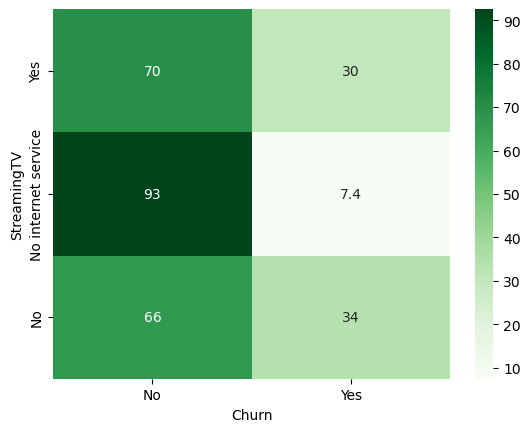

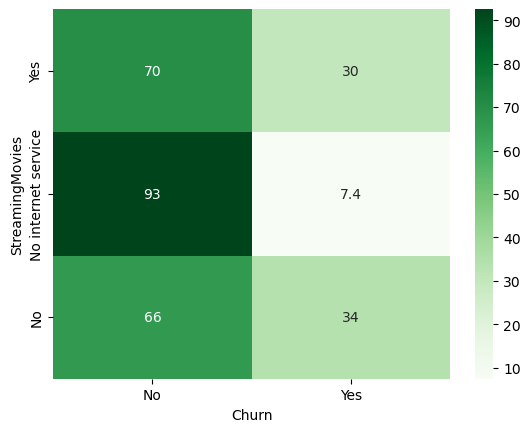

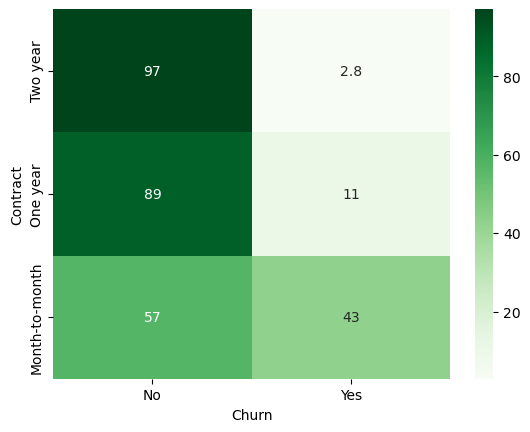

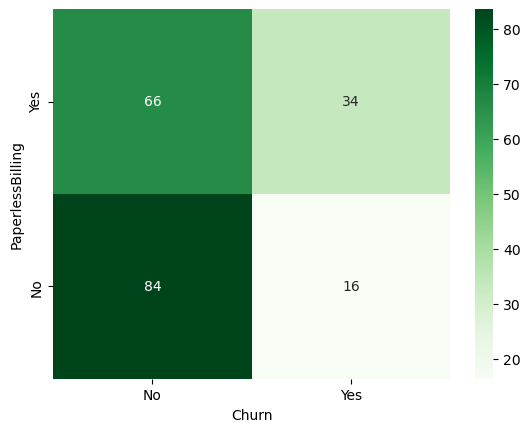

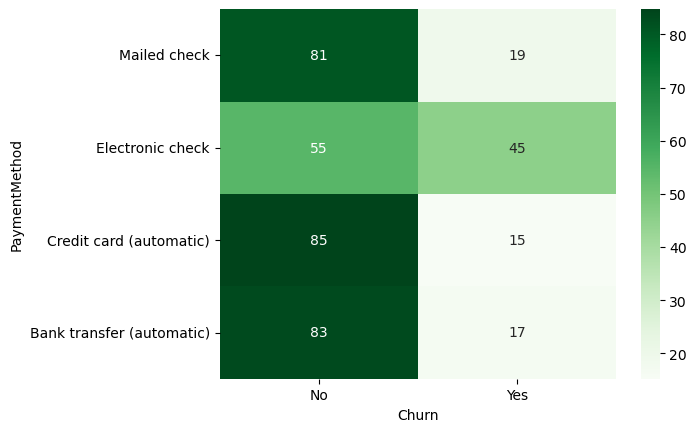

In [ ]:
for name in cat_cols:
    cross_tab = pd.DataFrame(pd.crosstab(df[name], df.Churn, normalize='index'))
    cross_tab = cross_tab * 100

    ax = sns.heatmap(cross_tab, annot = True, cmap="Greens")
    ax.invert_yaxis()
    plt.show();

### Test/Train split

In [ ]:
conv_cols = [col for col in df.columns if '_n' in col]
drop_cols = [re.sub('_n', "", x) for x in conv_cols]
drop_cols.remove('SeniorCitizen')
print(drop_cols)

['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn', 'gender']


In [ ]:
print(list(df.columns))

['customerID', 'gender', 'SeniorCitizen_n', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn', 'Partner_n', 'Dependents_n', 'PhoneService_n', 'PaperlessBilling_n', 'Churn_n', 'gender_n']


In [ ]:
#pd.crosstab(df.gender_n, columns = 'Count')

In [ ]:
y = df.Churn_n
X = df.drop(['Churn_n','customerID'] + drop_cols, axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.4,
                                                    stratify = y,
                                                    random_state = 222)

print(X_train.shape, X_test.shape)
# (4219, 20) (2813, 20)

print('Churn rate train (%): ', round(y_train[y_train == 1].shape[0]/y_train.shape[0]*100,2))
print('Churn rate test (%): ', round(y_test[y_test == 1].shape[0]/y_test.shape[0]*100,2))

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

X_train_orig = X_train.copy()

(4219, 19) (2813, 19)
Churn rate train (%):  26.57
Churn rate test (%):  26.59


### Examine the features

In [ ]:
y = y_train.copy()
X = X_train.copy()

for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

discrete_features = X.dtypes == int

In [ ]:
mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores

Contract              0.096910
tenure                0.083345
OnlineSecurity        0.063449
TechSupport           0.061518
InternetService       0.052963
MonthlyCharges        0.049854
PaymentMethod         0.048688
OnlineBackup          0.046357
DeviceProtection      0.041245
TotalCharges          0.039808
StreamingTV           0.030800
StreamingMovies       0.030745
PaperlessBilling_n    0.020531
Dependents_n          0.014876
Partner_n             0.011873
SeniorCitizen_n       0.010443
MultipleLines         0.000562
PhoneService_n        0.000062
gender_n              0.000000
Name: MI Scores, dtype: float64

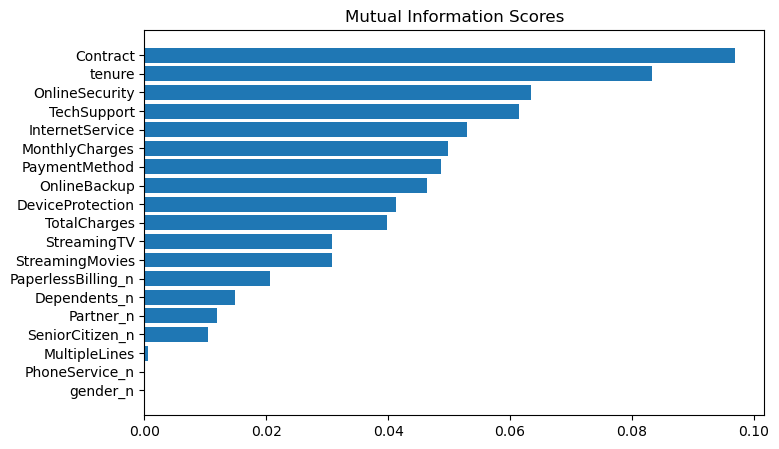

In [ ]:
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)
plt.show();

### Features from tree classification

In [ ]:
cat_cols = list(X_train.select_dtypes(include=['object']))
print(cat_cols)

ohe = OneHotEncoder()
ohe.fit(X_train[cat_cols])
colnames = ohe.get_feature_names_out(cat_cols)

cat_data_check = ohe_dset(X_train, cat_cols)
print(cat_data_check.shape)

['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']
(4219, 31)
(4219, 31)


In [ ]:
num_cols = list(X_train.select_dtypes(include=['number'], exclude=['datetime', 'timedelta']).columns)
print(num_cols)

['SeniorCitizen_n', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Partner_n', 'Dependents_n', 'PhoneService_n', 'PaperlessBilling_n', 'gender_n']


In [ ]:
X = pd.concat([X_train[num_cols], cat_data_check], axis = 1)
y = y_train

clf = DecisionTreeClassifier(max_depth=5, random_state=1234)
model = clf.fit(X, y)

In [ ]:
text_representation = tree.export_text(clf, feature_names=list(X.columns))

In [ ]:
rule_lst = []
flattened_lst = []

minutes = 2
t_end = time.time() + 60 * minutes

while time.time() < t_end:
    rules, proba = get_rules(clf, list(X.columns), [0,1], 80, 50)
    rule_lst.append(list(set(rules)))
    flattened_lst = [val for sublist in rule_lst for val in sublist]
    flattened_lst = list(set(flattened_lst))

In [ ]:
#flattened_lst

### New features

In [ ]:
for i, dset in enumerate([X_train, X_test]):

    dseta = dset.copy()
    dseta['feature_1'] = 0
    dseta.loc[(dseta.Contract != 'Month_to_month') &
              (dseta.MonthlyCharges <= 93.775) &
              (dseta.OnlineSecurity != 'No') &
              (dseta.MonthlyCharges > 65.4), 'feature_1'] = 1

    dseta['feature_2'] = 0
    dseta.loc[(dseta.Contract != 'Month_to_month') &
              (dseta.OnlineSecurity != 'No') &
              (dseta.MonthlyCharges <= 65.275) &
              (dseta.TotalCharges > 31.525), 'feature_2'] = 1

    dseta['feature_3'] = 0
    dseta.loc[(dseta.Contract != 'Month_to_month') &
              (dseta.MonthlyCharges > 93.775) &
              (dseta.tenure > 70.5) &
              (dseta.TotalCharges <= 8678.625) &
              (dseta.OnlineSecurity == 'Yes'), 'feature_3'] = 1

    dseta['feature_4'] = 0
    dseta.loc[(dseta.Contract != 'Month_to_month') &
              (dseta.MonthlyCharges <= 93.775) &
              (dseta.OnlineSecurity == 'No') &
              (dseta.MonthlyCharges > 35.1) &
              (dseta.tenure <= 46.5), 'feature_4'] = 1

    dseta['feature_5'] = 0
    dseta.loc[(dseta.Contract != 'Month_to_month') &
              (dseta.tenure <= 70.5) &
              (dseta.MonthlyCharges > 110.2), 'feature_5'] = 1

    dseta['feature_6'] = 0
    dseta.loc[(dseta.Contract != 'Month_to_month') &
              (dseta.MonthlyCharges > 93.95) &
              (dseta.tenure <= 70.5) &
              (dseta.MonthlyCharges <= 103.2), 'feature_6'] = 1

    dseta['feature_7'] = 0
    dseta.loc[(dseta.Contract != 'Month_to_month') &
              (dseta.MonthlyCharges <= 93.775) &
              (dseta.OnlineSecurity == 'No') &
              (dseta.MonthlyCharges > 35.1) &
              (dseta.tenure > 46.5), 'feature_7'] = 1

    dseta['feature_8'] = 0
    dseta.loc[(dseta.Contract == 'Month_to_month') &
              (dseta.InternetService == 'Fiber optic') &
              (dseta.tenure <= 10.5) &
              (dseta.TotalCharges <= 95.725) &
              (dseta.PaymentMethod != 'Credit card (automatic)'), 'feature_8'] = 1

    dseta['feature_9'] = 0
    dseta.loc[(dseta.Contract == 'Month_to_month') &
              (dseta.InternetService != 'Fiber optic') &
              (dseta.tenure > 17.5) &
              (dseta.PhoneService_n == 1), 'feature_9'] = 1

    if i == 0:
        X_train = dseta
    elif i == 1:
        X_test = dseta

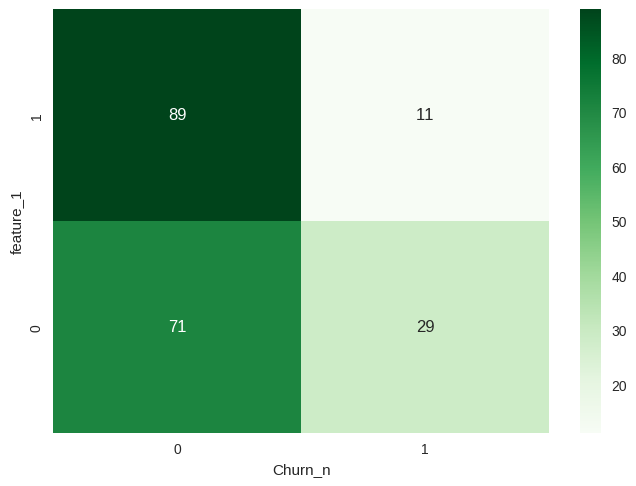

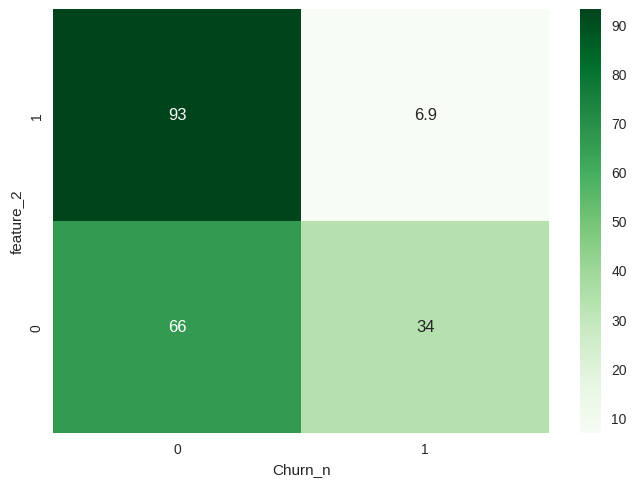

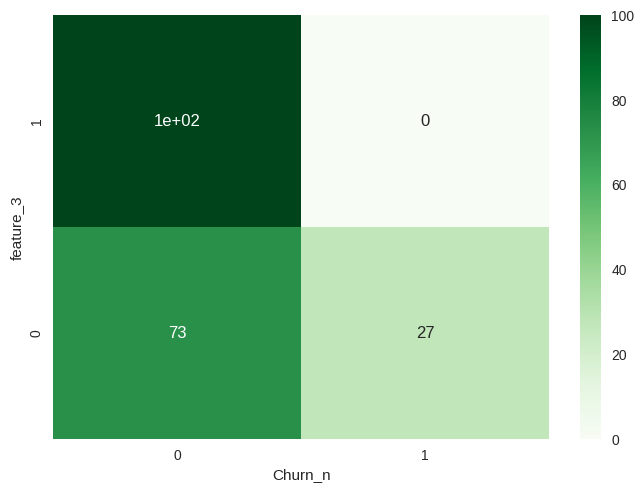

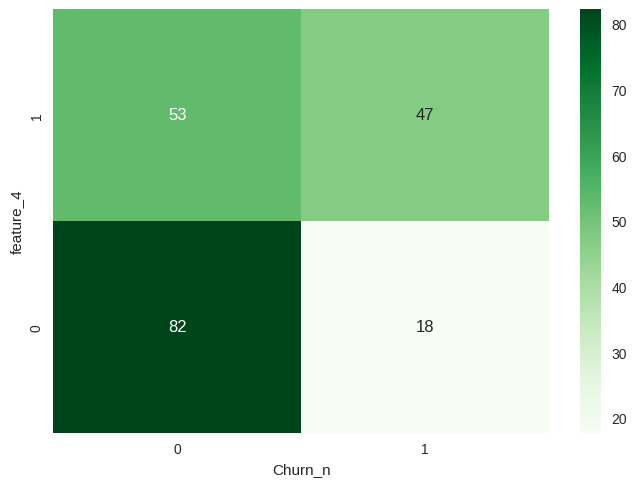

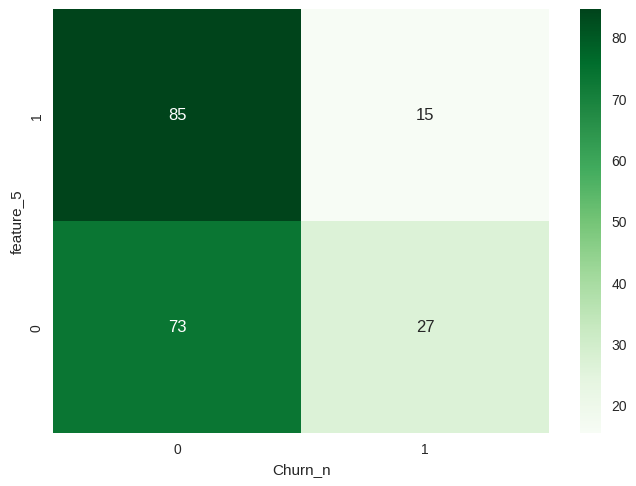

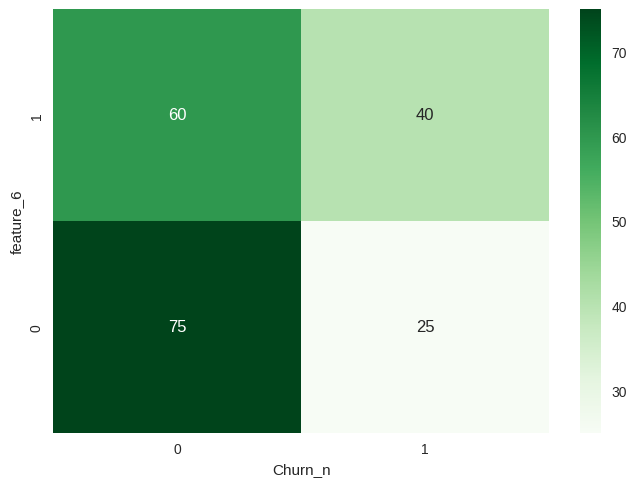

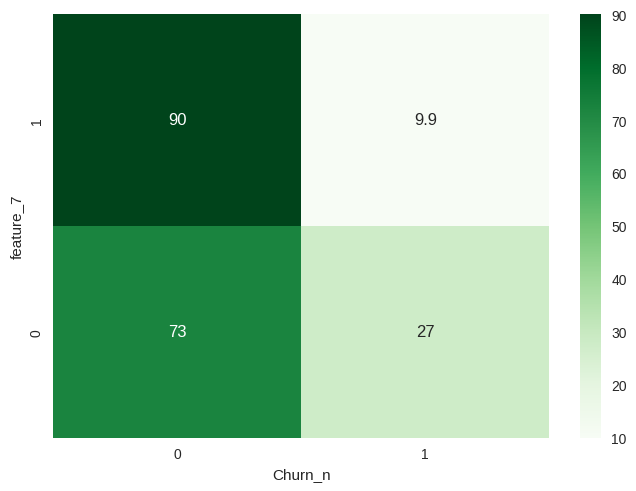

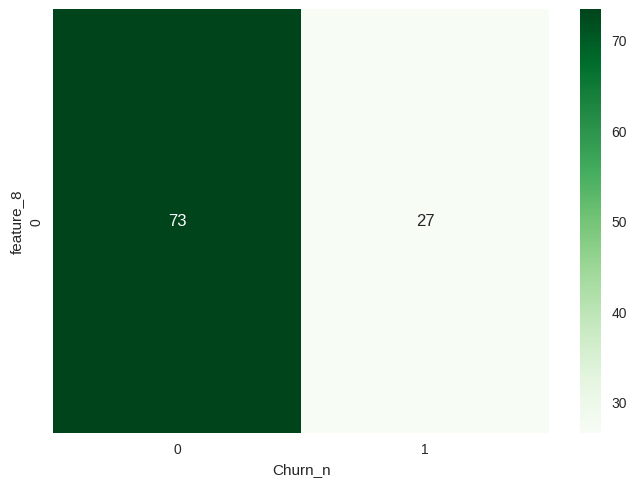

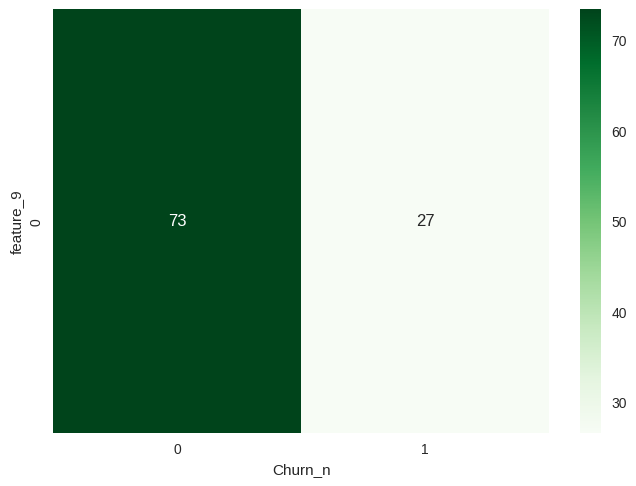

In [ ]:
for name in [col for col in X_train.columns if 'feature_' in col]:
    cross_tab = pd.DataFrame(pd.crosstab(X_train[name], y_train, normalize='index'))
    cross_tab = cross_tab * 100

    ax = sns.heatmap(cross_tab, annot = True, cmap="Greens")
    ax.invert_yaxis()
    plt.show();

### Binning data

In [ ]:
m_val_lst = ['MonthlyCharges','tenure']

for m_val in m_val_lst:
    X_train[m_val + '_bin'], bin_edges  = pd.qcut(X_train[m_val],
                                                   q = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1],
                                                   retbins = True,
                                                   duplicates = 'drop')
    print(m_val, bin_edges,range(len(bin_edges)-1))

    X_train[m_val + '_bin']  = pd.cut(X_train[m_val],
                                       bins = bin_edges,
                                       labels = range(len(bin_edges)-1),
                                       duplicates = 'drop',
                                       include_lowest=True)
    X_train[m_val + '_bin']  = X_train[m_val + '_bin'].astype(str)
    X_train.loc[X_train[m_val + '_bin'] == 'nan',m_val + '_bin'] = 'Missing'

    ### Test data ###
    X_test[m_val + '_bin'] = pd.cut(X_test[m_val],
                                    bins = bin_edges,
                                    labels = range(len(bin_edges)-1),
                                    include_lowest=True)

    X_test[m_val + '_bin'] = X_test[m_val + '_bin'].astype('str')
    X_test.loc[X_test[m_val + '_bin'] == 'nan',m_val + '_bin'] = 'Missing'



MonthlyCharges [ 18.25  20.05  25.23  48.64  59.56  70.6   79.2   85.53  94.2  101.81
 118.75] range(0, 10)
tenure [ 1.  2.  6. 12. 19. 28. 39. 50. 60. 69. 72.] range(0, 10)


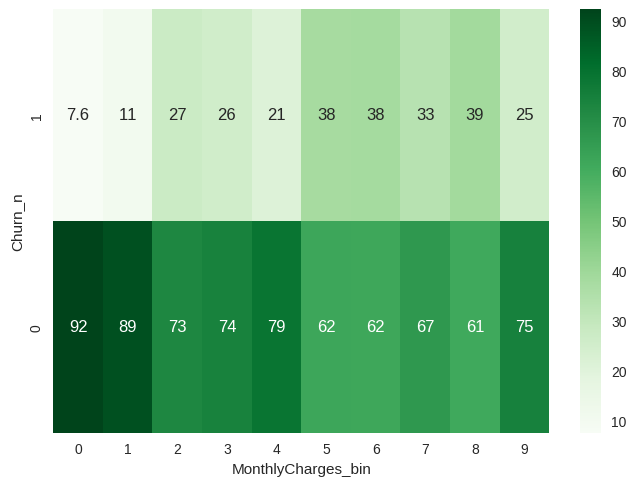

In [ ]:
pd.crosstab(X_train[m_val + '_bin'], columns = 'Count')

re_data = pd.concat([X_train,y_train], axis = 1)

room_t = pd.DataFrame(pd.crosstab(re_data['Churn_n'], re_data['MonthlyCharges_bin'], normalize='columns'))
room_t = room_t * 100

ax = sns.heatmap(room_t, annot = True, cmap="Greens")
ax.invert_yaxis()

### Preprocess the model data

In [ ]:
a = list(X_train.columns)
a.sort()
print(a)

X_train = X_train.drop(['tenure', 'MonthlyCharges'], axis = 1)
X_test = X_test.drop(['tenure', 'MonthlyCharges'], axis = 1)

['Contract', 'Dependents_n', 'DeviceProtection', 'InternetService', 'MonthlyCharges', 'MonthlyCharges_bin', 'MultipleLines', 'OnlineBackup', 'OnlineSecurity', 'PaperlessBilling_n', 'Partner_n', 'PaymentMethod', 'PhoneService_n', 'SeniorCitizen_n', 'StreamingMovies', 'StreamingTV', 'TechSupport', 'TotalCharges', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'gender_n', 'tenure', 'tenure_bin']


In [ ]:
#########################################
### Check for single non varying data ###
#########################################

lst = []
for name in list(X_train.columns):
    if (X_train[name].nunique() == 1):
        lst.append(name)

print(lst)

['feature_8', 'feature_9']


In [ ]:
#pd.crosstab(X_train.feature_8, columns = 'Count')

In [ ]:
try:
    X_train = X_train.drop(lst, axis = 1)
    X_test = X_test.drop(lst, axis = 1)
except:
    X_train = X_train
    X_test = X_test

In [ ]:
#########################
### Multicollinearity ###
#########################

num_cols = X_train.select_dtypes(include=np.number).columns.tolist()

vif = calculate_vif(X_train[num_cols])

a = vif[(vif.VIF > 10)]
to_drop_vif = list(a.Features)
print(to_drop_vif)
vif.sort_values(['VIF'], ascending = False)

[]


,Features,VIF
4,PhoneService_n,8.029081
1,TotalCharges,4.110605
10,feature_4,3.203689
2,Partner_n,2.804323
8,feature_2,2.686161
5,PaperlessBilling_n,2.559895
3,Dependents_n,1.940527
6,gender_n,1.940344
7,feature_1,1.907920
12,feature_6,1.819413


In [ ]:
num_cols = list(X_train.select_dtypes(include=['number'], exclude=['datetime', 'timedelta']).columns)
num_cols = (list(set(num_cols) - set([col for col in X_train.columns if '_n' in col])))
num_cols = (list(set(num_cols) - set([col for col in X_train.columns if 'feature_' in col])))
print(num_cols)

['TotalCharges']


[]


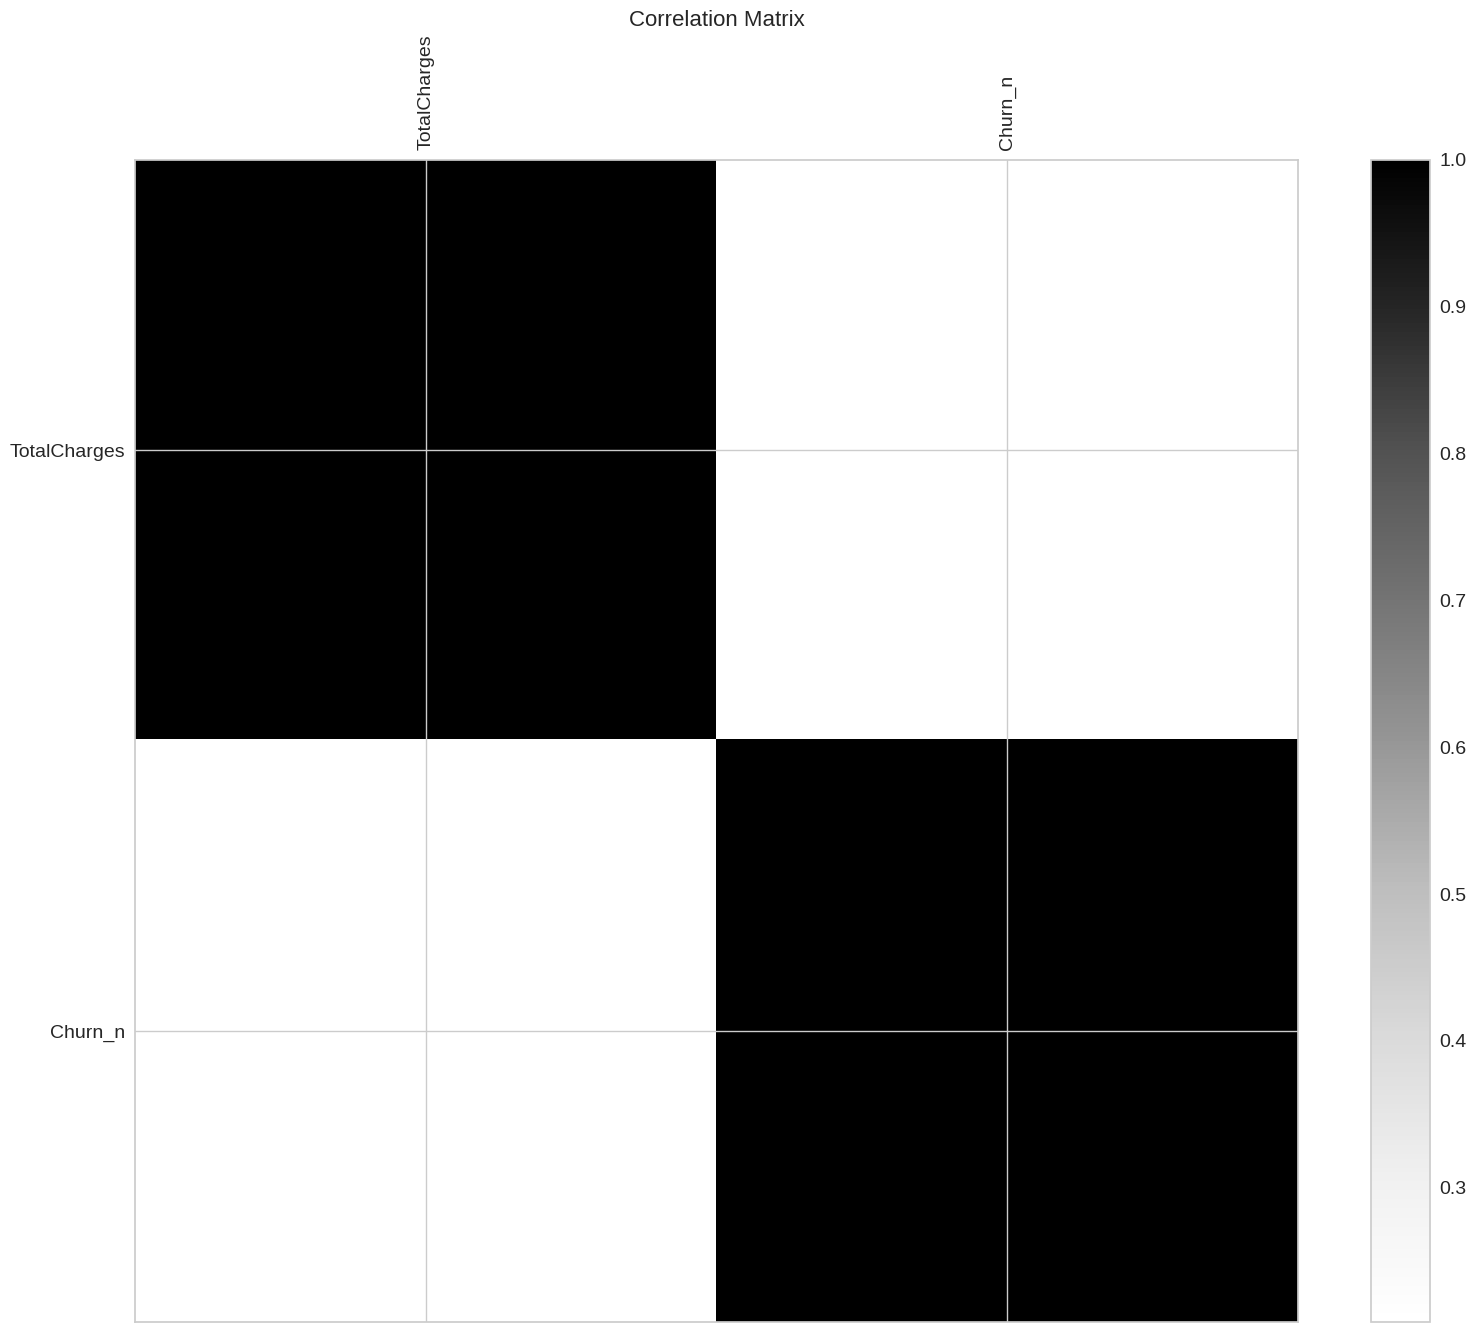

In [ ]:
###################
### Correlation ###
###################

corre_data = pd.concat([X_train[num_cols],
                        pd.DataFrame(y_train)],
                       axis = 1)

cor_matrix = corre_data.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))

to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8)]
print(to_drop)

f = plt.figure(figsize=(19, 15))
plt.matshow(cor_matrix, fignum=f.number)
plt.xticks(range(corre_data.select_dtypes(['number']).shape[1]),
           corre_data.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(corre_data.select_dtypes(['number']).shape[1]),
           corre_data.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)
plt.show();

In [ ]:
#####################
### MinMax scaler ###
#####################

print(X_train[num_cols].shape)

transformer_train = MinMaxScaler().fit(X_train[num_cols])
num_data_train = pd.DataFrame(transformer_train.transform(X_train[num_cols]))
num_data_train.columns = num_cols
print(num_data_train.shape)

num_data_test = minmax_dset(X_test,num_cols) ### Test ###

print(
    f'Data min:max {num_data_train.min().min(),num_data_train.max().max()}')

(4219, 1)
(4219, 1)
(2813, 1)
Data min:max (0.0, 0.9999999999999999)


In [ ]:
cat_cols = list(X_train.select_dtypes(include=['object']))
cat_cols = (list(set(cat_cols) - set([col for col in X_train.columns if '_bin' in col])))

In [ ]:
###################################
### High cardinality adjustment ###
###################################

card_vars = []
cat_data = X_train[cat_cols]
cat_data_vals = cat_data.copy()
for i in range(cat_data.shape[1]):
    print(cat_data.columns[i],len(list(set(cat_data.iloc[:,i]))))
    if (len(list(set(cat_data.iloc[:,i]))) > 60):
        print(cat_data.columns[i],len(list(set(cat_data.iloc[:,i]))))

        a = pd.crosstab(cat_data[cat_data.columns[i]],columns='Count')
        a = pd.DataFrame(a).sort_values('Count',ascending=False).reset_index()
        val_list = list(a.iloc[:20,0])
        cat_data_vals.loc[~cat_data_vals[cat_data.columns[i]].isin(val_list),cat_data.columns[i]] = 'Other'

    elif cat_data.iloc[:,i].nunique() > 100:
        print(cat_data.columns[i],len(list(set(cat_data.iloc[:,i]))))
        card_vars.append(cat_data.columns[i])

print(card_vars)

Contract 3
MultipleLines 3
StreamingTV 3
OnlineSecurity 3
TechSupport 3
PaymentMethod 4
StreamingMovies 3
DeviceProtection 3
InternetService 3
OnlineBackup 3
[]


In [ ]:
########################
### One hot encoding ###
########################

ohe = OneHotEncoder()
print(X_train.shape)
# (357127, 56)

### Train ###

ohe.fit(X_train[cat_cols])
colnames = ohe.get_feature_names_out(cat_cols)

cat_data_train = ohe_dset(X_train,cat_cols)  ### Train ###

for name in list(cat_data_train.columns):
    cat_data_train[name] = cat_data_train[name].astype(int)

cat_data_test = ohe_dset(X_test,cat_cols)    ### Test ###

print(cat_data_train.shape)
cat_data_train.head()

print(
    f'Data min:max {cat_data_train.min().min(),cat_data_train.max().max()}')

(4219, 26)
(4219, 31)
(2813, 31)
(4219, 31)
Data min:max (0, 1)


In [ ]:
print([col for col in X_train.columns if '_bin' in col])
#pd.crosstab(X_train['tenure_bin'], columns = 'Count')

['MonthlyCharges_bin', 'tenure_bin']


In [ ]:
ordinal_encoder_bin = OrdinalEncoder(categories=[['Missing','0','1','2','3','4','5','6','7','8','9']])
ordinal_encoder_bin.fit(pd.DataFrame(X_train['MonthlyCharges_bin']))
ord_data_train = pd.DataFrame(ordinal_encoder_bin.transform(pd.DataFrame(X_train['MonthlyCharges_bin'])),columns = ['MonthlyCharges_bin'])
ord_data_test = pd.DataFrame(ordinal_encoder_bin.transform(pd.DataFrame(X_test['MonthlyCharges_bin'])), columns = ['MonthlyCharges_bin'])

ordinal_encoder_bin.fit(pd.DataFrame(X_train['tenure_bin']))
ord_data_train['tenure_bin'] = ordinal_encoder_bin.transform(pd.DataFrame(X_train['tenure_bin']))
ord_data_test['tenure_bin'] = ordinal_encoder_bin.transform(pd.DataFrame(X_test['tenure_bin']))

for name in ['MonthlyCharges_bin','tenure_bin']:
    ord_data_train[name] = ord_data_train[name].astype(int)

transformer_train_o = MinMaxScaler().fit(ord_data_train)
ord_data_train = pd.DataFrame(transformer_train_o.transform(ord_data_train))
ord_data_train.columns = ['MonthlyCharges_bin','tenure_bin']

print(
    f'Training data min:max {ord_data_train.min().min(),ord_data_train.max().max()}')

for name in ['MonthlyCharges_bin','tenure_bin']:
    ord_data_test[name] = ord_data_test[name].astype(int)

transformer_test_o = MinMaxScaler().fit(ord_data_test)
ord_data_test = pd.DataFrame(transformer_test_o.transform(ord_data_test))
ord_data_test.columns = ['MonthlyCharges_bin','tenure_bin']

print(
    f'Test data min:max {ord_data_test.min().min(),ord_data_test.max().max()}')

Training data min:max (0.0, 1.0)
Test data min:max (0.0, 1.0)


In [ ]:
print([col for col in X_train.columns if '_n' in col])
print([col for col in X_train.columns if 'feature_' in col])
bin_data_train = X_train[[col for col in X_train.columns if '_n' in col] + [col for col in X_train.columns if 'feature_' in col]]
bin_data_test = X_test[[col for col in X_train.columns if '_n' in col] + [col for col in X_train.columns if 'feature_' in col]]

['SeniorCitizen_n', 'Partner_n', 'Dependents_n', 'PhoneService_n', 'PaperlessBilling_n', 'gender_n']
['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7']


In [ ]:
cat_data_train = cat_data_train[(list(set(list(cat_data_train.columns)) - set(['level_0', 'index'])))]
num_data_train = num_data_train[(list(set(list(num_data_train.columns)) - set(['level_0', 'index'])))]
ord_data_train = ord_data_train[(list(set(list(ord_data_train.columns)) - set(['level_0', 'index'])))]
bin_data_train = bin_data_train[(list(set(list(bin_data_train.columns)) - set(['level_0', 'index'])))]

cat_data_test = cat_data_test[(list(set(list(cat_data_test.columns)) - set(['level_0', 'index'])))]
num_data_test = num_data_test[(list(set(list(num_data_test.columns)) - set(['level_0', 'index'])))]
ord_data_test = ord_data_test[(list(set(list(ord_data_test.columns)) - set(['level_0', 'index'])))]
bin_data_test = bin_data_test[(list(set(list(bin_data_test.columns)) - set(['level_0', 'index'])))]

In [ ]:
print("Categorical data", list(cat_data_train.columns))
print("Numerical data", list(num_data_train.columns))
print("Ordinal data", list(ord_data_train.columns))
print("Binned data", list(bin_data_train.columns))

Categorical data ['StreamingMovies_No internet service', 'DeviceProtection_No internet service', 'TechSupport_Yes', 'DeviceProtection_No', 'StreamingTV_Yes', 'StreamingMovies_No', 'TechSupport_No', 'Contract_One year', 'PaymentMethod_Credit card (automatic)', 'OnlineSecurity_No', 'Contract_Month-to-month', 'OnlineBackup_No internet service', 'StreamingTV_No internet service', 'TechSupport_No internet service', 'DeviceProtection_Yes', 'InternetService_DSL', 'MultipleLines_No', 'StreamingMovies_Yes', 'OnlineSecurity_No internet service', 'OnlineSecurity_Yes', 'MultipleLines_Yes', 'PaymentMethod_Mailed check', 'MultipleLines_No phone service', 'OnlineBackup_No', 'InternetService_Fiber optic', 'InternetService_No', 'Contract_Two year', 'OnlineBackup_Yes', 'PaymentMethod_Electronic check', 'StreamingTV_No', 'PaymentMethod_Bank transfer (automatic)']
Numerical data ['TotalCharges']
Ordinal data ['tenure_bin', 'MonthlyCharges_bin']
Binned data ['feature_3', 'feature_5', 'PaperlessBilling_n', 

In [ ]:
###########################
### Bring data together ###
###########################

print(cat_data_train.shape, num_data_train.shape, ord_data_train.shape, bin_data_train.shape)
cat_data_train = cat_data_train.reset_index()
num_data_train = num_data_train.reset_index()
ord_data_train = ord_data_train.reset_index()
bin_data_train = bin_data_train.reset_index()

X_train_mod = pd.concat([cat_data_train,num_data_train],axis = 1)
X_train_mod = pd.concat([X_train_mod,ord_data_train],axis = 1)
X_train_mod = pd.concat([X_train_mod,bin_data_train],axis = 1)
print(X_train_mod.shape)

print(cat_data_test.shape, num_data_test.shape, bin_data_test.shape)
cat_data_test = cat_data_test.reset_index()
num_data_test = num_data_test.reset_index()
bin_data_test = bin_data_test.reset_index()
X_test_mod = pd.concat([cat_data_test,num_data_test],axis = 1)
X_test_mod = pd.concat([X_test_mod,ord_data_test],axis = 1)
X_test_mod = pd.concat([X_test_mod,bin_data_test],axis = 1)
print(X_test_mod.shape)

print(X_train_mod.shape, X_test_mod.shape)

(4219, 31) (4219, 1) (4219, 2) (4219, 13)
(4219, 51)
(2813, 31) (2813, 1) (2813, 13)
(2813, 50)
(4219, 51) (2813, 50)


In [ ]:
####################################################
### Check that train/test sets have same columns ###
####################################################

try:
    X_train_cols = list(set(X_train_mod.columns))
    X_train_cols.remove('index')
    X_train_mod = X_train_mod[X_train_cols]

except:
    X_train_mod = X_train_mod

try:
    X_train_cols = list(set(X_train_mod.columns))
    X_train_cols.remove('level_0')
    X_train_mod = X_train_mod[X_train_cols]

except:
    X_train_mod = X_train_mod

mod_cols = (list(set(list(X_train_mod.columns)) - set(['index'])))
X_train_mod = X_train_mod[mod_cols]
miss_lst = list(set(list(X_train_mod.columns)) - set(list(X_test_mod.columns)))

for name in miss_lst:
    X_test_mod[name] = 0
X_test_mod = X_test_mod[list(X_train_mod.columns)]

drop_test_lst = list(set(list(X_test_mod.columns)) - set(list(X_train_mod.columns)))
X_test_mod = X_test_mod.drop(drop_test_lst, axis = 1)


print(X_train_mod.shape, X_test_mod.shape)
# (64215, 105) (42811, 135) (10148, 107)


(4219, 47) (2813, 47)


In [ ]:
a = list(X_train_mod.columns)
a.sort()
print(a)

['Contract_Month-to-month', 'Contract_One year', 'Contract_Two year', 'Dependents_n', 'DeviceProtection_No', 'DeviceProtection_No internet service', 'DeviceProtection_Yes', 'InternetService_DSL', 'InternetService_Fiber optic', 'InternetService_No', 'MonthlyCharges_bin', 'MultipleLines_No', 'MultipleLines_No phone service', 'MultipleLines_Yes', 'OnlineBackup_No', 'OnlineBackup_No internet service', 'OnlineBackup_Yes', 'OnlineSecurity_No', 'OnlineSecurity_No internet service', 'OnlineSecurity_Yes', 'PaperlessBilling_n', 'Partner_n', 'PaymentMethod_Bank transfer (automatic)', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check', 'PhoneService_n', 'SeniorCitizen_n', 'StreamingMovies_No', 'StreamingMovies_No internet service', 'StreamingMovies_Yes', 'StreamingTV_No', 'StreamingTV_No internet service', 'StreamingTV_Yes', 'TechSupport_No', 'TechSupport_No internet service', 'TechSupport_Yes', 'TotalCharges', 'feature_1', 'feature_2', 'feature

### Clustering

100%|██████████| 18/18 [00:06<00:00,  2.99it/s]


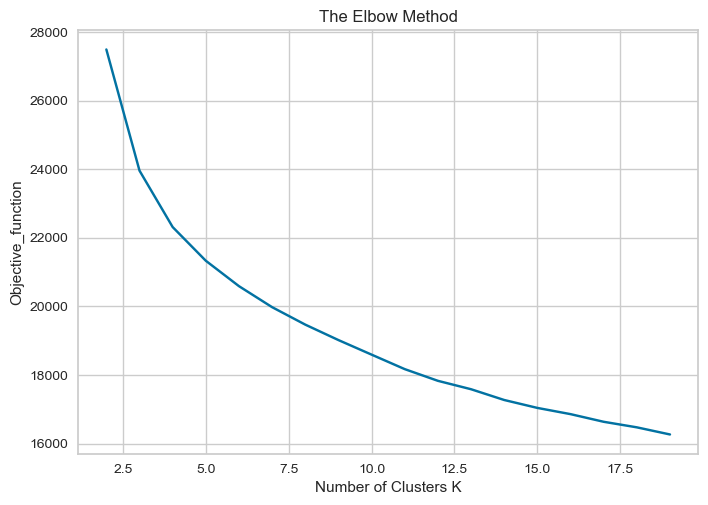

In [ ]:
all_data = pd.concat([X_train_mod, y_train], axis = 1)

objective_function = []
for i in tqdm(range(2, 20)):
    clustering = KMeans(n_clusters=i, init='k-means++')
    clustering.fit(all_data)
    objective_function.append(clustering.inertia_)

plt.plot(range(2, 20), objective_function)
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters K')
plt.ylabel('Objective_function')
plt.show()

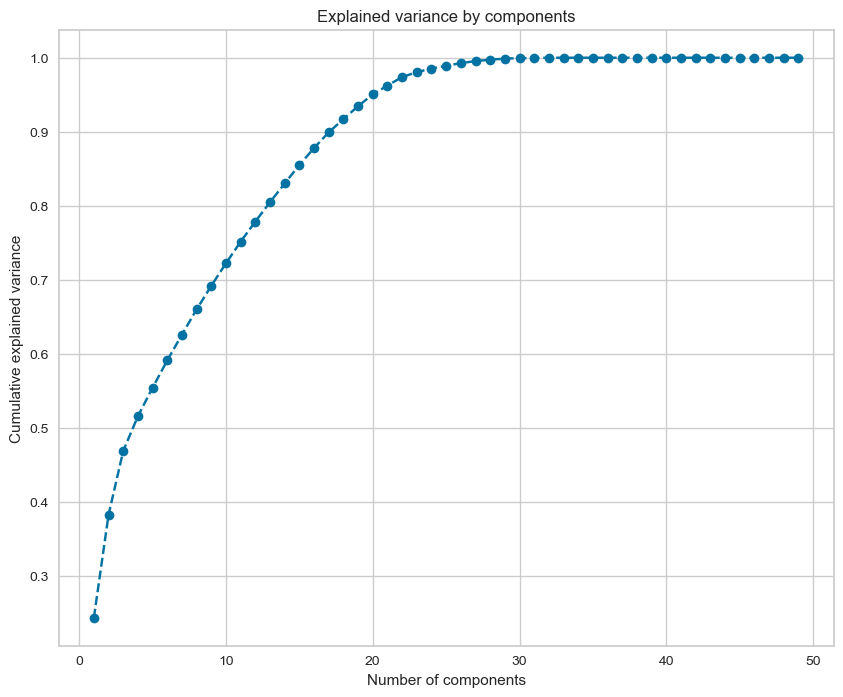

In [ ]:
###########
### PCA ###
###########

pca = PCA()
pca.fit(all_data)

plt.figure(figsize=(10,8))
plt.plot(range(1,len(pca.explained_variance_ratio_.cumsum())+1), pca.explained_variance_ratio_.cumsum(),
         marker='o',linestyle='--')
plt.title("Explained variance by components")
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.show();

In [ ]:
pca = PCA(n_components=13)
pca.fit(all_data)
scores_pca = pca.transform(all_data)

100%|██████████| 38/38 [00:16<00:00,  2.33it/s]


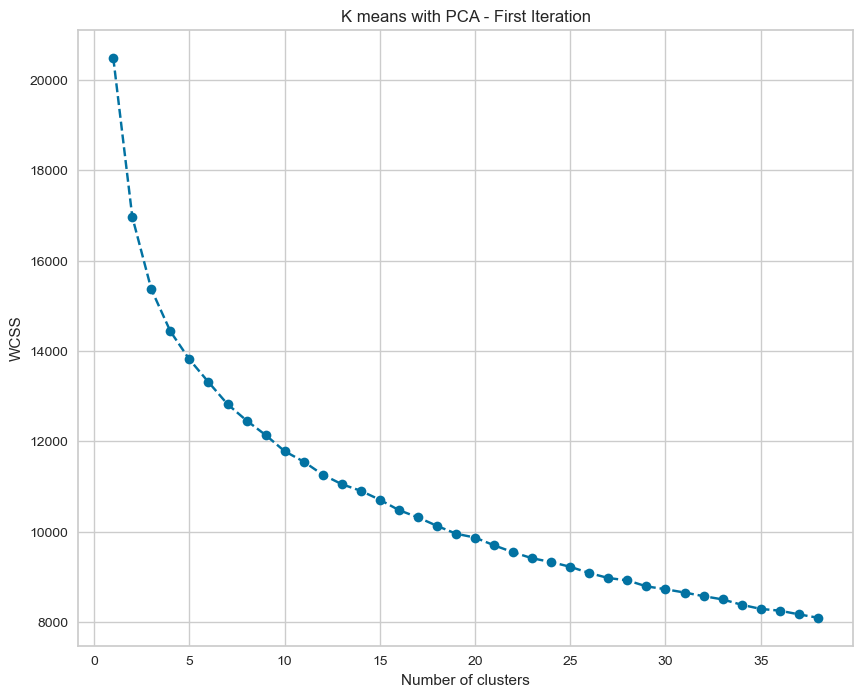

In [ ]:
wcss = []
for i in tqdm(range(2,40)):
    kmeans_pca = KMeans(n_clusters = i, init = "k-means++", random_state = 42)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)

plt.figure(figsize=(10, 8))
plt.plot(range(1, len(wcss)+1), wcss,
         marker='o', linestyle='--')
plt.title("K means with PCA - First Iteration")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show();

In [ ]:
tuned_clustering = KMeans(n_clusters=15, init='k-means++', random_state=0)
labels = tuned_clustering.fit_predict(all_data)

metrics.silhouette_score(
    all_data, tuned_clustering.labels_, metric='euclidean')

0.11928568091541258

In [ ]:
kmeans_pca = KMeans(n_clusters=15, init="k-means++", random_state=42)
kmeans_pca.fit(scores_pca)
print(pd.DataFrame(scores_pca).shape)
df_segm_pca_means = pd.concat(
    [all_data.reset_index(drop=True), pd.DataFrame(scores_pca)],axis=1)

df_segm_pca_means.columns.values[-13:] = ['Component 1', 'Component 2','Component 3','Component 4','Component 5',
                                          'Component 6', 'Component 7','Component 8','Component 9','Component 10',
                                          'Component 11', 'Component 12','Component 13']
df_segm_pca_means['Clusters'] = kmeans_pca.labels_
plt.show()

(4219, 13)


In [ ]:
#df_segm_pca_means.head()
#pd.DataFrame(scores_pca).head()
pd.crosstab(df_segm_pca_means.Clusters, columns = 'Count')
print(df_segm_pca_means.shape)

(4219, 63)


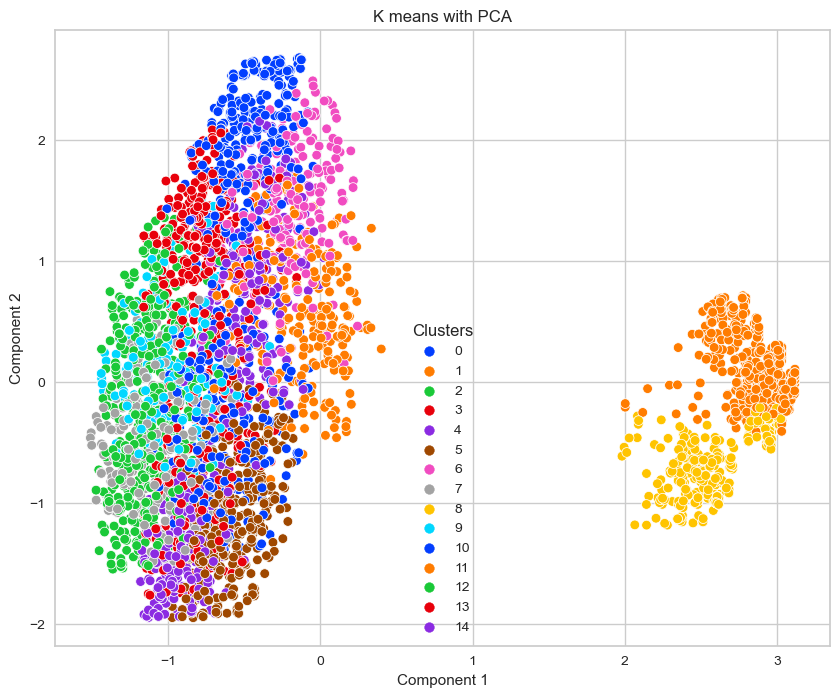

In [ ]:
x_axis = df_segm_pca_means['Component 1']
y_axis = df_segm_pca_means['Component 2']
plt.figure(figsize=(10, 8))
sns.scatterplot(x=x_axis, y=y_axis, hue=df_segm_pca_means['Clusters'], palette="bright")
plt.title("K means with PCA")
plt.show();

In [ ]:
num_cols = list(df.select_dtypes(include=['number'], exclude=['datetime', 'timedelta']).columns)
num_cols = (list(set(num_cols) - set([col for col in df.columns if '_n' in col])))
print(num_cols)

['tenure', 'TotalCharges', 'MonthlyCharges']


In [ ]:
pd.crosstab(clus_data.Clusters.isna(), columns = 'Count')

col_0,Count
Clusters,
False,4219
True,2820


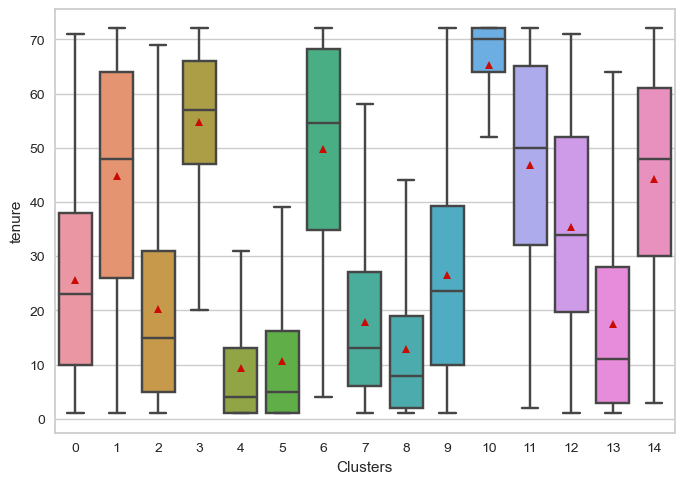

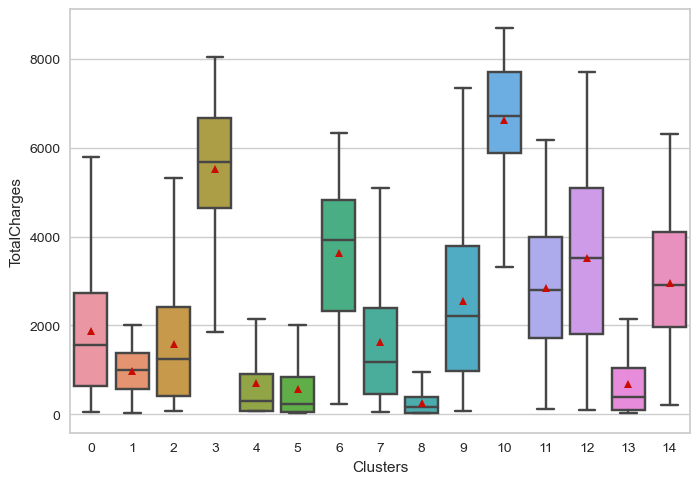

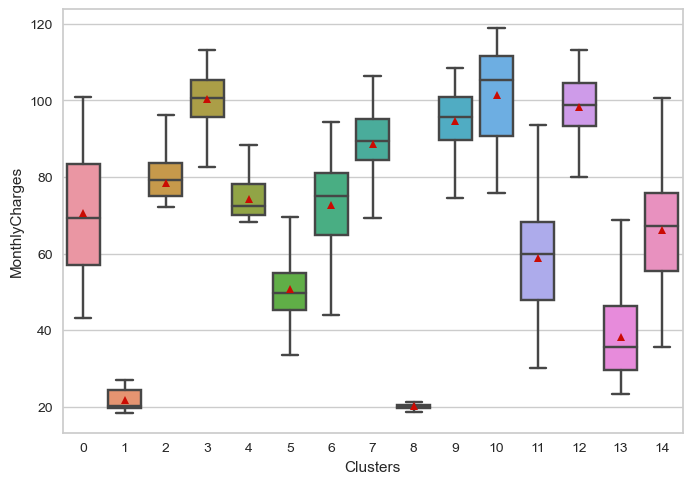

In [ ]:
clus_data = pd.concat([df_segm_pca_means['Clusters'],X_train_orig], axis = 1)
clus_data['Clusters'] = clus_data['Clusters'].astype(int)

for name in num_cols:
    sns.boxplot(data=clus_data, x="Clusters", y=name, showmeans = True, showfliers = False)
    plt.xlabel("Clusters")
    plt.ylabel(name)
    plt.show()

In [ ]:
cat_cols = list(clus_data.select_dtypes(include=['object']))
print(cat_cols)

['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']


In [ ]:
r = [0,1,2,3,4]
raw_data = {'greenBars': [20, 1.5, 7, 10, 5], 'orangeBars': [5, 15, 5, 10, 15],'blueBars': [2, 15, 18, 5, 10]}
df = pd.DataFrame(raw_data)

# From raw value to percentage
totals = [i+j+k for i,j,k in zip(df['greenBars'], df['orangeBars'], df['blueBars'])]
greenBars = [i / j * 100 for i,j in zip(df['greenBars'], totals)]
orangeBars = [i / j * 100 for i,j in zip(df['orangeBars'], totals)]
blueBars = [i / j * 100 for i,j in zip(df['blueBars'], totals)]

print(totals)
print(greenBars)

[27.0, 31.5, 30.0, 25.0, 30.0]
[74.07407407407408, 4.761904761904762, 23.333333333333332, 40.0, 16.666666666666664]


In [ ]:
target_t = pd.DataFrame(pd.crosstab(clus_data.Clusters, clus_data.MultipleLines, normalize='index'))
target_t = target_t * 100
target_t = pd.DataFrame(target_t)
target_t = target_t.reset_index()
target_t

MultipleLines,Clusters,No,No phone service,Yes
0,0,66.532258,0.403226,33.064516
1,1,65.120968,0.000000,34.879032
2,2,0.000000,0.000000,100.000000
3,3,27.147766,0.000000,72.852234
4,4,100.000000,0.000000,0.000000
5,5,87.500000,5.232558,7.267442
6,6,42.857143,27.678571,29.464286
7,7,44.890511,0.000000,55.109489
8,8,94.694960,0.000000,5.305040
9,9,39.705882,0.000000,60.294118


In [ ]:
print(bars3)

[0.0, 0.0, 100.0]


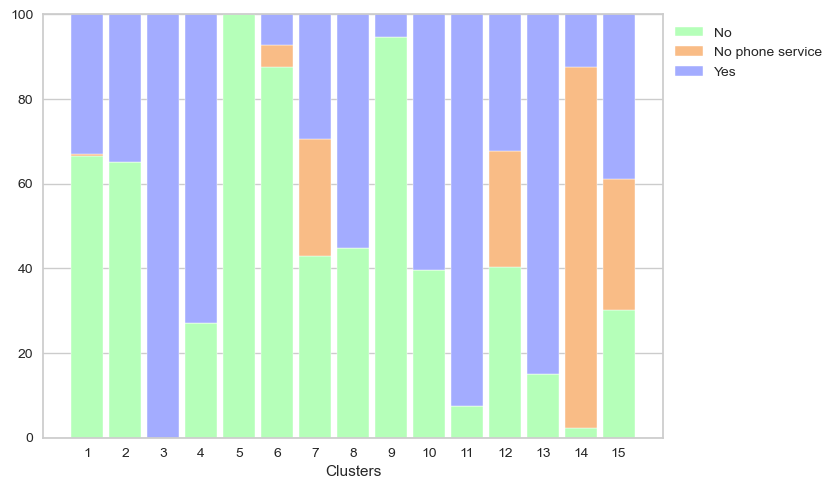

In [ ]:
r = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]

bars1 = list(target_t.iloc[:,1])
bars2 = list(target_t.iloc[:,2])
bars3 = list(target_t.iloc[:,3])

# plot
barWidth = 0.85
names = ('1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15')
# Create green Bars
plt.bar(r, bars1, color='#b5ffb9', edgecolor='white', width=barWidth, label = 'No')
# Create orange Bars
plt.bar(r, bars2, bottom=bars1, color='#f9bc86', edgecolor='white', width=barWidth, label = 'No phone service')
# Create blue Bars
plt.bar(r, bars3, bottom=[i+j for i,j in zip(bars1, bars2)], color='#a3acff', edgecolor='white', width=barWidth, label = 'Yes')

# Custom x axis
plt.xticks(r, names)
plt.xlabel("Clusters")

plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)

# Show graphic
plt.show()

In [ ]:
barWidth = 0.05

# set heights of bars
bars1 = list(target_t.iloc[0,1:])
bars2 = list(target_t.iloc[1,1:])
bars3 = list(target_t.iloc[2,1:])
bars4 = list(target_t.iloc[3,1:])
bars5 = list(target_t.iloc[4,1:])
bars6 = list(target_t.iloc[5,1:])
bars7 = list(target_t.iloc[6,1:])
bars8 = list(target_t.iloc[7,1:])
bars9 = list(target_t.iloc[8,1:])
bars10 = list(target_t.iloc[9,1:])
bars11 = list(target_t.iloc[10,1:])
bars12 = list(target_t.iloc[11,1:])
bars13 = list(target_t.iloc[12,1:])
bars14 = list(target_t.iloc[13,1:])
bars15 = list(target_t.iloc[14,1:])

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
r6 = [x + barWidth for x in r5]
r7 = [x + barWidth for x in r6]
r8 = [x + barWidth for x in r7]
r9 = [x + barWidth for x in r8]
r10 = [x + barWidth for x in r9]
r11 = [x + barWidth for x in r10]
r12 = [x + barWidth for x in r11]
r13 = [x + barWidth for x in r12]
r14 = [x + barWidth for x in r13]
r15 = [x + barWidth for x in r14]

# Make the plot
plt.bar(r1, bars1, color='forestgreen', width=barWidth, edgecolor='white', label='var1')
plt.bar(r2, bars2, color='limegreen', width=barWidth, edgecolor='white', label='var2')
plt.bar(r3, bars3, color='lime', width=barWidth, edgecolor='white', label='var3')
plt.bar(r4, bars4, color='springgreen', width=barWidth, edgecolor='white', label='var4')
plt.bar(r5, bars5, color='royalblue', width=barWidth, edgecolor='white', label='var5')
plt.bar(r6, bars6, color='blue', width=barWidth, edgecolor='white', label='var6')
plt.bar(r7, bars7, color='navy', width=barWidth, edgecolor='white', label='var7')
plt.bar(r8, bars8, color='mediumslateblue', width=barWidth, edgecolor='white', label='var8')
plt.bar(r9, bars9, color='dodgerblue', width=barWidth, edgecolor='white', label='var9')
plt.bar(r10, bars10, color='cyan', width=barWidth, edgecolor='white', label='var10')
plt.bar(r11, bars11, color='mediumpurple', width=barWidth, edgecolor='white', label='var11')
plt.bar(r12, bars12, color='blueviolet', width=barWidth, edgecolor='white', label='var12')
plt.bar(r13, bars13, color='magenta', width=barWidth, edgecolor='white', label='var13')
plt.bar(r14, bars14, color='violet', width=barWidth, edgecolor='white', label='var14')
plt.bar(r15, bars15, color='deeppink', width=barWidth, edgecolor='white', label='var15')

#https://stackoverflow.com/questions/22408237/named-colors-in-matplotlib

# Add xticks on the middle of the group bars
plt.xlabel('Cluster', fontweight='bold')
plt.xticks([r + barWidth + 0.1 for r in range(len(bars1))], ['No', 'No phone service', 'Yes'])

# Create legend & Show graphic
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

NameError: ignored

### Models

#### Baseline

In [ ]:
########################################################
### Check the performance on all the baseline models ###
########################################################

models = select_model(X_train_mod, y_train)

`use_label_encoder` is deprecated in 1.7.0.
 80%|████████  | 8/10 [00:20<00:10,  5.49s/it]`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
100%|██████████| 10/10 [00:23<00:00,  2.32s/it]


In [ ]:
models.head(20)

,model,run_time,accuracy
0,AdaBoostClassifier,0.03,0.842087
1,RidgeClassifier,0.01,0.840848
2,CatBoostClassifier,0.25,0.837379
3,LGBMClassifier,0.02,0.836811
4,SGDClassifier,0.01,0.836784
5,XGBClassifier,0.04,0.824235
6,BernoulliNB,0.01,0.821487
9,DecisionTreeClassifier,0.01,0.664949
7,ExtraTreeClassifier,0.01,0.661190
8,DummyClassifier,0.0,0.500000


#### Catboost

In [ ]:
######################################
### CatBoost hyperparameter tuning ###
######################################

%%time

pbounds = {"n_estimators": (150,400),
           "depth": (2,7),
           "learning_rate": (0.01, 0.2),
           "subsample":(0.6, 1.0),
           "num_leaves": (16,40),
           "max_bin":(150,300),
           "l2_leaf_reg":(2,10),
           "model_size_reg": (0,10)
}
optimizer = BayesianOptimization(
    f = CB_opt,
    pbounds = pbounds,
    verbose = 2,
    random_state = 888,
)

optimizer.maximize(init_points = 15, n_iter = 25)

print(optimizer.max)


print("CV score: {:<8.5f}".format(CB_opt(int(optimizer.max['params']['n_estimators']),
                                         round(optimizer.max['params']['depth'],0),
                                         optimizer.max['params']['learning_rate'],
                                         round(optimizer.max['params']['max_bin'],0),
                                         optimizer.max['params']['subsample'],
                                         round(optimizer.max['params']['num_leaves'],0),
                                         optimizer.max['params']['l2_leaf_reg'],
                                         optimizer.max['params']['model_size_reg'])))

###########################
### Fit the tuned model ###
###########################

cboost_model_hy = CatBoostClassifier(depth = round(optimizer.max['params']['depth'],0),
                                    l2_leaf_reg = optimizer.max['params']['l2_leaf_reg'],
                                    learning_rate = optimizer.max['params']['learning_rate'],
                                    max_bin = round(optimizer.max['params']['max_bin'],0),
                                    n_estimators = int(optimizer.max['params']['n_estimators']),
                                    num_leaves = round(optimizer.max['params']['num_leaves'],0),
                                    subsample = optimizer.max['params']['subsample'],
                                    random_state = 88,
                                    grow_policy = "Lossguide",
                                    verbose = 0,
                                    eval_metric = "AUC")

ValueError: ignored

In [ ]:
#################################
### LGBM Hyperparamter tuning ###
#################################

import lightgbm as lgb

%time

### prepare data ###

train_data = lgb.Dataset(data = X_train_mod,
                         label = y_train,
                         free_raw_data = False)

### parameters ###

lgbBO = BayesianOptimization(lgb_eval, {'learning_rate': (0.01, 1.0),
                                        'num_leaves': (24, 80),
                                        'feature_fraction': (0.1, 0.9),
                                        'bagging_fraction': (0.8, 1),
                                        'max_depth': (5, 30),
                                        'max_bin':(20,90),
                                        'min_data_in_leaf': (20, 80),
                                        'min_sum_hessian_in_leaf':(0,100),
                                        'subsample': (0.01, 1.0)},
                             random_state=200)


lgbBO.maximize(init_points = 15,
               n_iter = 25)

model_auc=[]
for model in range(len( lgbBO.res)):
    model_auc.append(lgbBO.res[model]['target'])

    # return best parameters
opt_params_lbgm = lgbBO.res[pd.Series(model_auc).idxmax()]['target'],lgbBO.res[pd.Series(model_auc).idxmax()]['params']

opt_params_lbgm[1]["num_leaves"] = int(round(opt_params_lbgm[1]["num_leaves"]))
opt_params_lbgm[1]['max_depth'] = int(round(opt_params_lbgm[1]['max_depth']))
opt_params_lbgm[1]['min_data_in_leaf'] = int(round(opt_params_lbgm[1]['min_data_in_leaf']))
opt_params_lbgm[1]['max_bin'] = int(round(opt_params_lbgm[1]['max_bin']))
opt_params_lbgm[1]['objective']='binary'
opt_params_lbgm[1]['metric']='auc'
opt_params_lbgm[1]['is_unbalance']=True
opt_params_lbgm[1]['boost_from_average']=False
opt_params_lbgm = opt_params_lbgm[1]

print(opt_params_lbgm)

folds = StratifiedKFold(n_splits=10,
                        shuffle=True,
                        random_state=31416)
folds.get_n_splits(X_train_mod, y_train)

oof = np.zeros(len(X_train_mod))
predictions = np.zeros(len(X_test_mod))

for train_index, test_index in folds.split(X_train_mod, y_train):

    trainx, x_test_cv = X_train_mod.iloc[train_index], X_train_mod.iloc[test_index]
    trainy, y_test_cv = pd.DataFrame(y_train).iloc[train_index], pd.DataFrame(y_train).iloc[test_index]

    trn_data = lgb.Dataset(trainx,
                           label = trainy)
    val_data = lgb.Dataset(x_test_cv,
                           label = y_test_cv)

    num_round = 15000
    lbgm_model_hy = lgb.train(opt_params_lbgm,
                              trn_data,
                              num_round,
                              valid_sets = [trn_data, val_data],
                              verbose_eval = 500,
                              early_stopping_rounds = 250)

    oof[test_index] = lbgm_model_hy.predict(x_test_cv, num_iteration = lbgm_model_hy.best_iteration)

    predictions += lbgm_model_hy.predict(X_test_mod, num_iteration = lbgm_model_hy.best_iteration) / folds.n_splits
    pred_labels = np.rint(predictions)

print("CV score: {:<8.5f}".format(roc_auc_score(y_test,predictions)))

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


TypeError: ignored

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


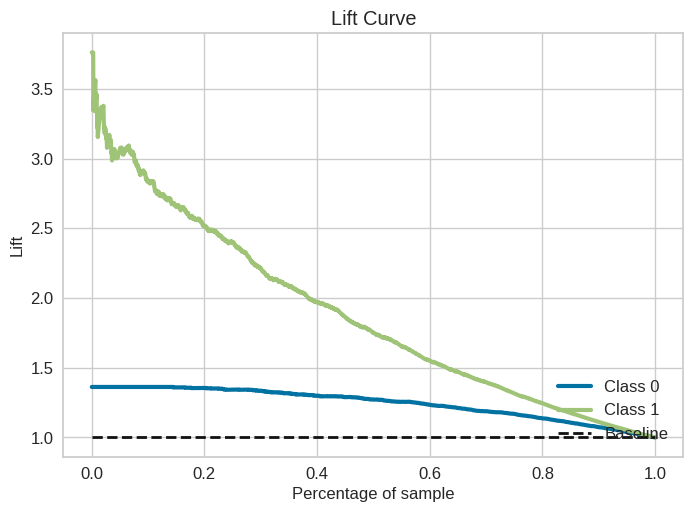

In [ ]:
lr = LogisticRegression()
lr.fit(X_train_mod, y_train)
probas = lr.predict_proba(X_test_mod)
skplt.metrics.plot_lift_curve(y_true = y_test, y_probas = probas)
plt.show()

#### Neural Network

In [ ]:
print(X_train_mod.shape)
X_train_nn = X_train_mod.iloc[3600:]
X_val_nn = X_train_mod.iloc[:3600]
y_train_nn = y_train.iloc[3600:]
y_val_nn = y_train.iloc[:3600]
print(X_train_nn.shape, X_val_nn.shape, y_train_nn.shape, y_val_nn.shape)

(4219, 47)
(619, 47) (3600, 47) (619,) (3600,)


In [ ]:
n_inputs = X_train_nn.shape[1]

nn_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    #Dense(20, activation='relu'),
    #Dense(15, activation='relu'),
    #Dense(10, activation='relu'),
    #Dense(1, activation='sigmoid')
    Dense(1, activation='linear')
])

In [ ]:
#nn_model.compile(Adam(learning_rate = 0.0001), loss = BinaryCrossEntropy(from_logits = True), metrics = ['accuracy']) # multiclass
nn_model.compile(Adam(learning_rate = 0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])


In [ ]:
#X_train = np.asarray(X_train_mod).astype(np.float32)
#X_test = np.asarray(X_test_mod).astype(np.float32)

history = nn_model.fit(X_train_nn, y_train_nn, batch_size=25, epochs=100, verbose=2, validation_data=(X_val_nn, y_val_nn))

Epoch 1/100
25/25 - 1s - loss: 0.6379 - accuracy: 0.6688 - val_loss: 0.6165 - val_accuracy: 0.7028 - 1s/epoch - 55ms/step
Epoch 2/100
25/25 - 0s - loss: 0.6078 - accuracy: 0.7157 - val_loss: 0.5905 - val_accuracy: 0.7278 - 373ms/epoch - 15ms/step
Epoch 3/100
25/25 - 0s - loss: 0.5844 - accuracy: 0.7302 - val_loss: 0.5688 - val_accuracy: 0.7339 - 253ms/epoch - 10ms/step
Epoch 4/100
25/25 - 0s - loss: 0.5654 - accuracy: 0.7351 - val_loss: 0.5521 - val_accuracy: 0.7336 - 257ms/epoch - 10ms/step
Epoch 5/100
25/25 - 0s - loss: 0.5497 - accuracy: 0.7334 - val_loss: 0.5396 - val_accuracy: 0.7344 - 243ms/epoch - 10ms/step
Epoch 6/100
25/25 - 0s - loss: 0.5379 - accuracy: 0.7367 - val_loss: 0.5286 - val_accuracy: 0.7342 - 375ms/epoch - 15ms/step
Epoch 7/100
25/25 - 0s - loss: 0.5278 - accuracy: 0.7367 - val_loss: 0.5197 - val_accuracy: 0.7342 - 249ms/epoch - 10ms/step
Epoch 8/100
25/25 - 0s - loss: 0.5195 - accuracy: 0.7367 - val_loss: 0.5124 - val_accuracy: 0.7339 - 379ms/epoch - 15ms/step
Epo

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

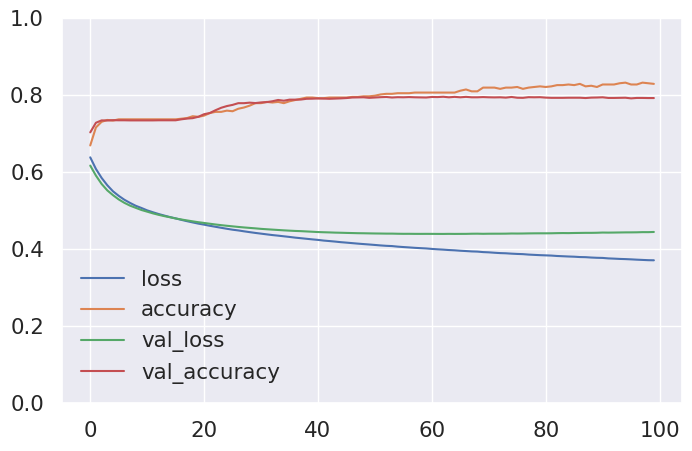

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

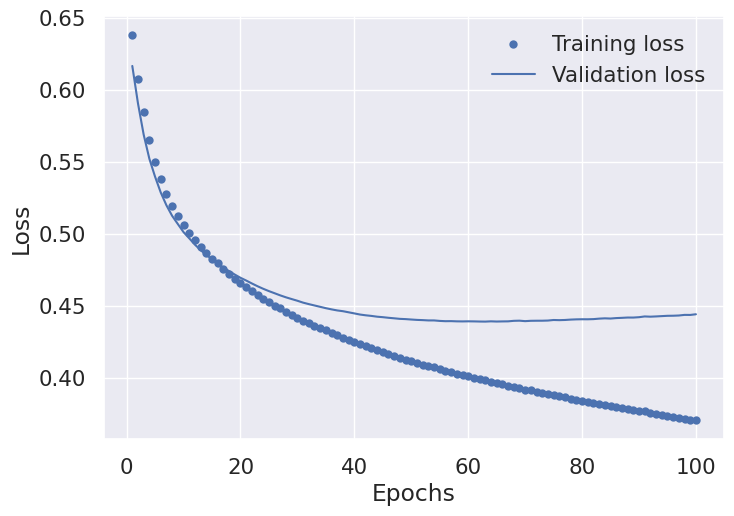

In [ ]:
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

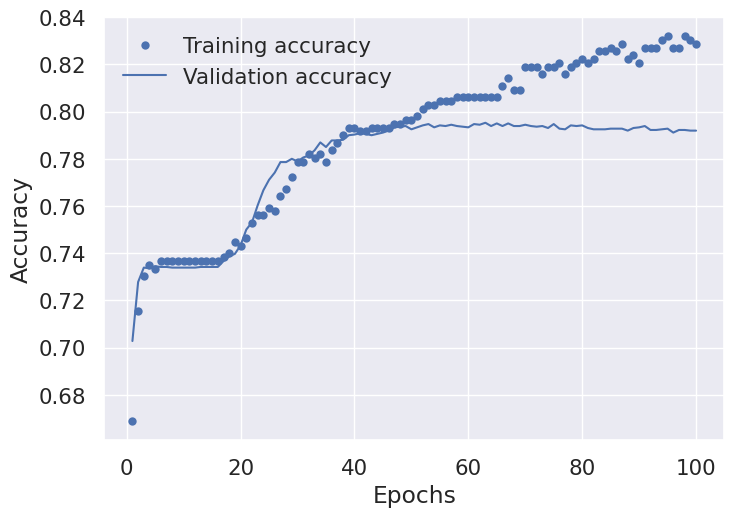

In [ ]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

plt.plot(epochs, acc, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
X_test = np.asarray(X_test_mod).astype(np.float32)

nn_model_predictions = nn_model.predict(X_test, batch_size=200, verbose=0)
nn_model_class_predictions = np.argmax(nn_model_predictions, axis=1)

ROC/AUC: 0.5
Accuracy: 0.7340917170280838
F1 score: 0.0
132/132 [==============================] - 0s 1ms/step


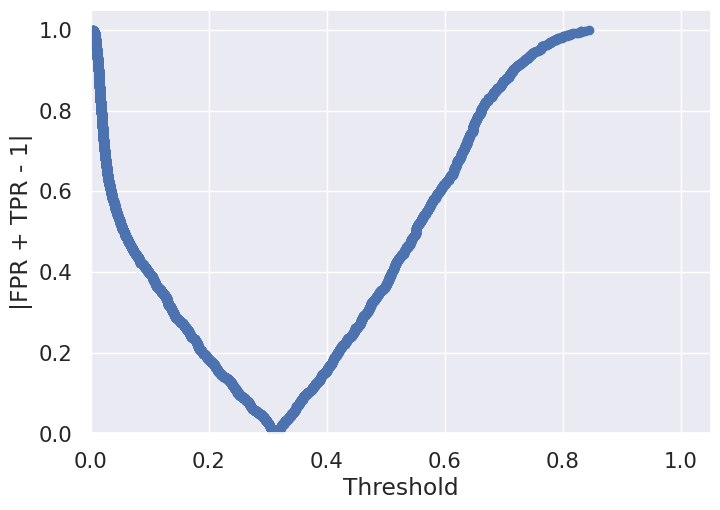

Threshold: 0.3141768
88/88 [==============================] - 0s 1ms/step
ROC/AUC threshold: 0.7538931905581955
Accuracy threshold: 0.7657305367934589
F1 score threshold: 0.6232132647226987


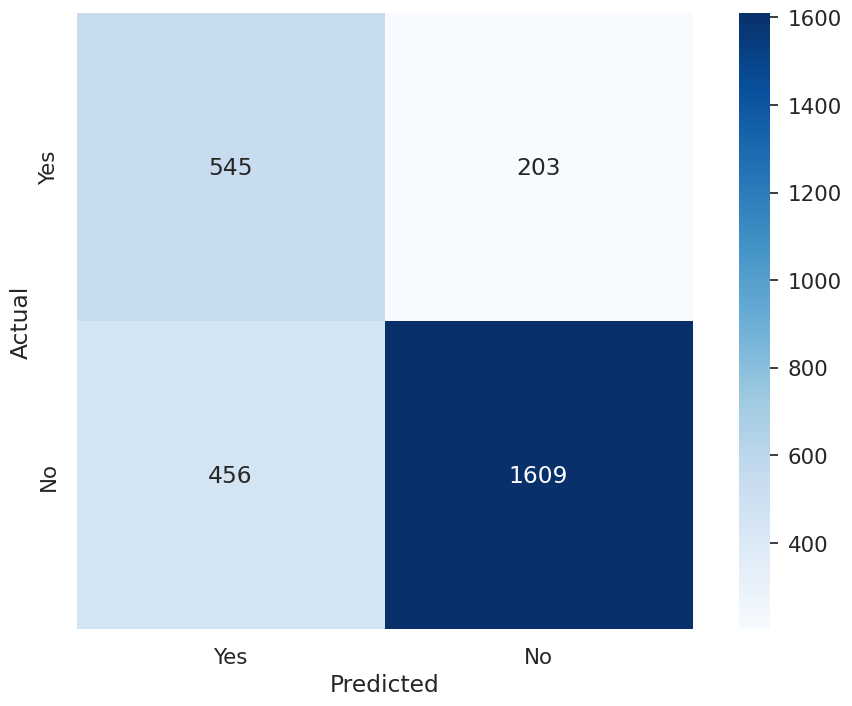

In [ ]:
roc_auc_nn, accuracy_nn, f1_score_nn, threshold_nn = diag_vals(nn_model)

#### Callback model

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

n_inputs = X_train_nn.shape[1]

nn_model_cb = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(20, activation='relu'),
    Dense(15, activation='relu'),
    Dense(10, activation='relu'),
    #Dense(1, activation='sigmoid')
    Dense(1, activation='linear')
])

In [ ]:
nn_model_cb.compile(Adam(learning_rate = 0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])
#nn_model_cb.compile(Adam(learning_rate = 0.0001), loss = BinaryCrossEntropy(from_logits = True), metrics = ['accuracy']) # multiclass


checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)

#X_train = np.asarray(X_train_mod).astype(np.float32)
#X_test = np.asarray(X_test_mod).astype(np.float32)

history = nn_model_cb.fit(X_train_nn, y_train_nn,
                          batch_size=25,
                          epochs=100,
                          verbose=2,
                          validation_data=(X_val_nn, y_val_nn),
                          callbacks=[checkpoint_cb, early_stopping_cb])

model_cb = keras.models.load_model("my_keras_model.h5") # rollback to best model
cb_test = model_cb.evaluate(X_test, y_test)

Epoch 1/100
25/25 - 2s - loss: 0.7136 - accuracy: 0.2698 - val_loss: 0.7089 - val_accuracy: 0.2872 - 2s/epoch - 99ms/step
Epoch 2/100
25/25 - 0s - loss: 0.7043 - accuracy: 0.3118 - val_loss: 0.7024 - val_accuracy: 0.3517 - 433ms/epoch - 17ms/step
Epoch 3/100
25/25 - 0s - loss: 0.6986 - accuracy: 0.3829 - val_loss: 0.6977 - val_accuracy: 0.4497 - 428ms/epoch - 17ms/step
Epoch 4/100
25/25 - 0s - loss: 0.6946 - accuracy: 0.5040 - val_loss: 0.6942 - val_accuracy: 0.5347 - 435ms/epoch - 17ms/step
Epoch 5/100
25/25 - 0s - loss: 0.6913 - accuracy: 0.6058 - val_loss: 0.6912 - val_accuracy: 0.5975 - 311ms/epoch - 12ms/step
Epoch 6/100
25/25 - 0s - loss: 0.6883 - accuracy: 0.6624 - val_loss: 0.6884 - val_accuracy: 0.6453 - 434ms/epoch - 17ms/step
Epoch 7/100
25/25 - 0s - loss: 0.6852 - accuracy: 0.6963 - val_loss: 0.6855 - val_accuracy: 0.6806 - 315ms/epoch - 13ms/step
Epoch 8/100
25/25 - 0s - loss: 0.6820 - accuracy: 0.7270 - val_loss: 0.6823 - val_accuracy: 0.7061 - 442ms/epoch - 18ms/step
Epo

In [ ]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))

In [ ]:
val_train_ratio_cb = PrintValTrainRatioCallback()
val_train_ratio_cb

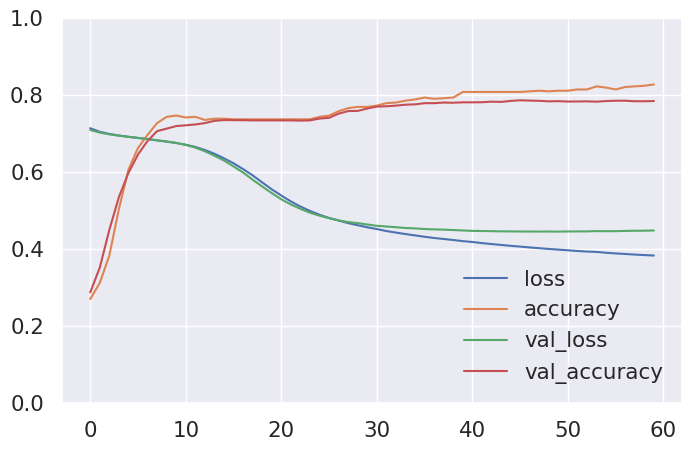

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
nn_model_predictions_cb = model_cb.predict(X_test, batch_size=200, verbose=0)
nn_model_class_predictions_cb = np.argmax(nn_model_predictions_cb, axis=1)

ROC/AUC: 0.5
Accuracy: 0.7340917170280838
F1 score: 0.0
132/132 [==============================] - 0s 1ms/step


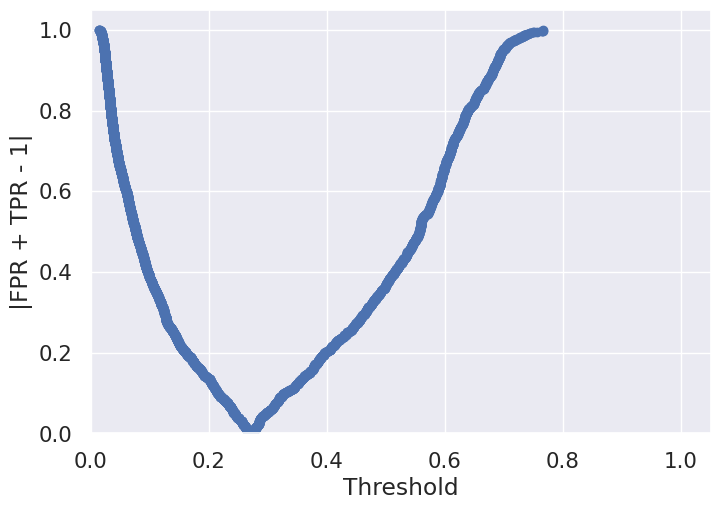

Threshold: 0.2708696
88/88 [==============================] - 0s 1ms/step
ROC/AUC threshold: 0.7449136357162279
Accuracy threshold: 0.7575542125844295
F1 score threshold: 0.6116173120728929


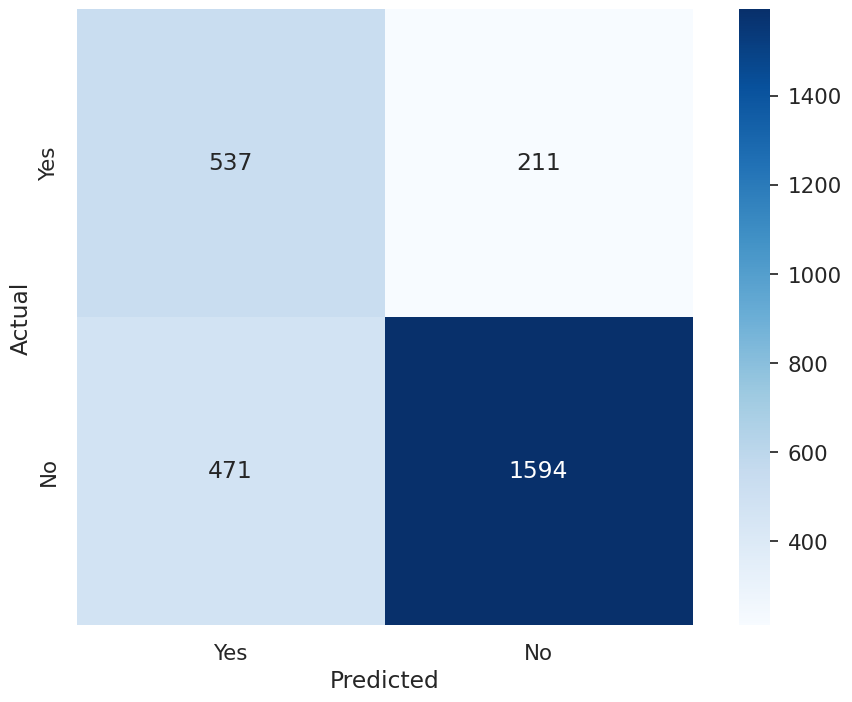

In [ ]:
roc_auc_cb, accuracy_cb, f1_score_cb, threshold_nn = diag_vals(model_cb)

#### Hyperparameter NN

In [ ]:
input_shape = (X_train_nn.shape[1],)
hypermodel = ClfHyperModel(input_shape)

In [ ]:
tuner_rs = RandomSearch(
            hypermodel,
            objective=kt.Objective("val_auc", direction="max"),
            seed=42,
            max_trials=20,
            executions_per_trial=2,
            overwrite=True,
            directory="my_dir",
            project_name="helloworld",)

In [ ]:
#tuner_rs.search(X_train_nn, y_train_nn, epochs=40, validation_split=0.2, verbose=1, callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])
tuner_rs.search(X_train_nn, y_train_nn, epochs=40, validation_data=(X_val_nn, y_val_nn), verbose=1, callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])

Trial 20 Complete [00h 01m 07s]
val_auc: 0.8233046531677246

Best val_auc So Far: 0.8309762179851532
Total elapsed time: 00h 15m 11s


In [ ]:
best_hps=tuner_rs.get_best_hyperparameters(num_trials=1)[0]

print(f"""
units = {best_hps.get('units')}
optimizer = {best_hps.get('optimizer')}
activation = {best_hps.get('dense_activation')}
dropout = {best_hps.get('dropout')}
batch_size = {best_hps.get('batch_size')}
learning_rate = {best_hps.get('learning_rate')}
""")


units = 16
optimizer = Adam
activation = tanh
dropout = 0.0
batch_size = 128
learning_rate = 0.001



In [ ]:
tuned_model = tuner_rs.hypermodel.build(best_hps)

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)

history_tm = tuned_model.fit(x = X_train_nn,
                y = y_train_nn,
                epochs = 100,
                verbose = 2,
                validation_data=(X_val_nn, y_val_nn),
                callbacks=[checkpoint_cb, early_stopping_cb]
)

Epoch 1/100
20/20 - 1s - loss: 0.6492 - auc_1: 0.4850 - val_loss: 0.5942 - val_auc_1: 0.5527 - 1s/epoch - 71ms/step
Epoch 2/100
20/20 - 0s - loss: 0.5458 - auc_1: 0.6682 - val_loss: 0.5262 - val_auc_1: 0.7281 - 379ms/epoch - 19ms/step
Epoch 3/100
20/20 - 0s - loss: 0.5010 - auc_1: 0.7701 - val_loss: 0.4936 - val_auc_1: 0.7765 - 369ms/epoch - 18ms/step
Epoch 4/100
20/20 - 0s - loss: 0.4756 - auc_1: 0.8022 - val_loss: 0.4755 - val_auc_1: 0.7946 - 376ms/epoch - 19ms/step
Epoch 5/100
20/20 - 0s - loss: 0.4616 - auc_1: 0.8128 - val_loss: 0.4650 - val_auc_1: 0.8053 - 377ms/epoch - 19ms/step
Epoch 6/100
20/20 - 0s - loss: 0.4521 - auc_1: 0.8159 - val_loss: 0.4568 - val_auc_1: 0.8098 - 372ms/epoch - 19ms/step
Epoch 7/100
20/20 - 0s - loss: 0.4448 - auc_1: 0.8204 - val_loss: 0.4524 - val_auc_1: 0.8140 - 376ms/epoch - 19ms/step
Epoch 8/100
20/20 - 0s - loss: 0.4400 - auc_1: 0.8241 - val_loss: 0.4487 - val_auc_1: 0.8170 - 444ms/epoch - 22ms/step
Epoch 9/100
20/20 - 0s - loss: 0.4360 - auc_1: 0.82

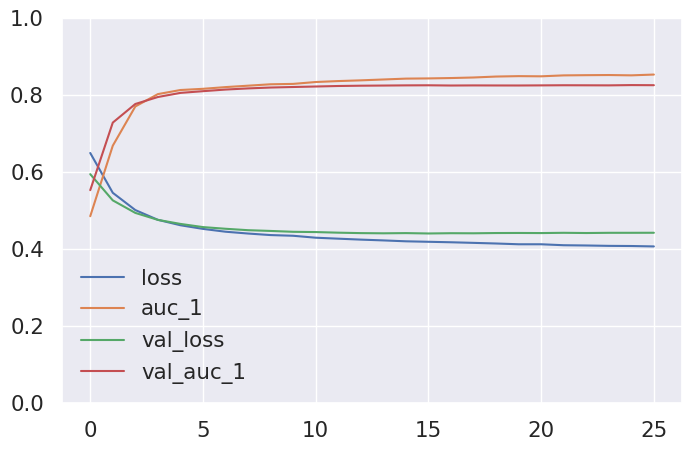

In [ ]:
pd.DataFrame(history_tm.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
tnn_model_predictions = tuned_model.predict(X_test, batch_size=100, verbose=0)
tnn_model_class_predictions = np.argmax(tnn_model_predictions, axis=1)

ROC/AUC: 0.5
Accuracy: 0.7340917170280838
F1 score: 0.0
132/132 [==============================] - 0s 759us/step


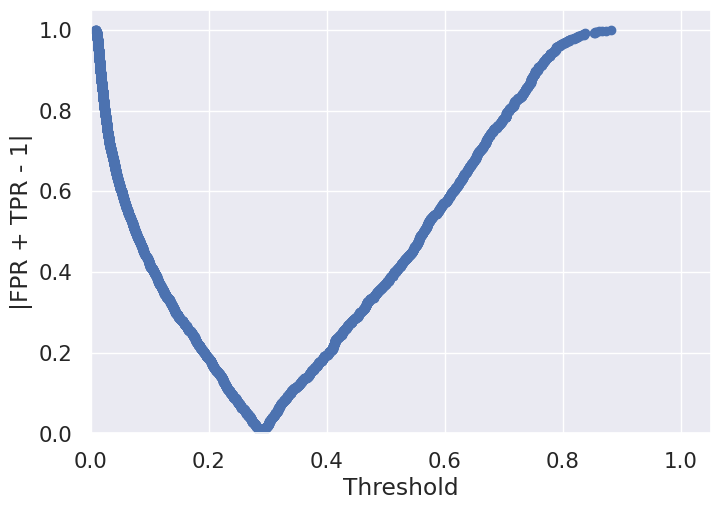

Threshold: 0.28883153
88/88 [==============================] - 0s 784us/step
ROC/AUC threshold: 0.7591145394983879
Accuracy threshold: 0.7696409527195165
F1 score threshold: 0.6297142857142857


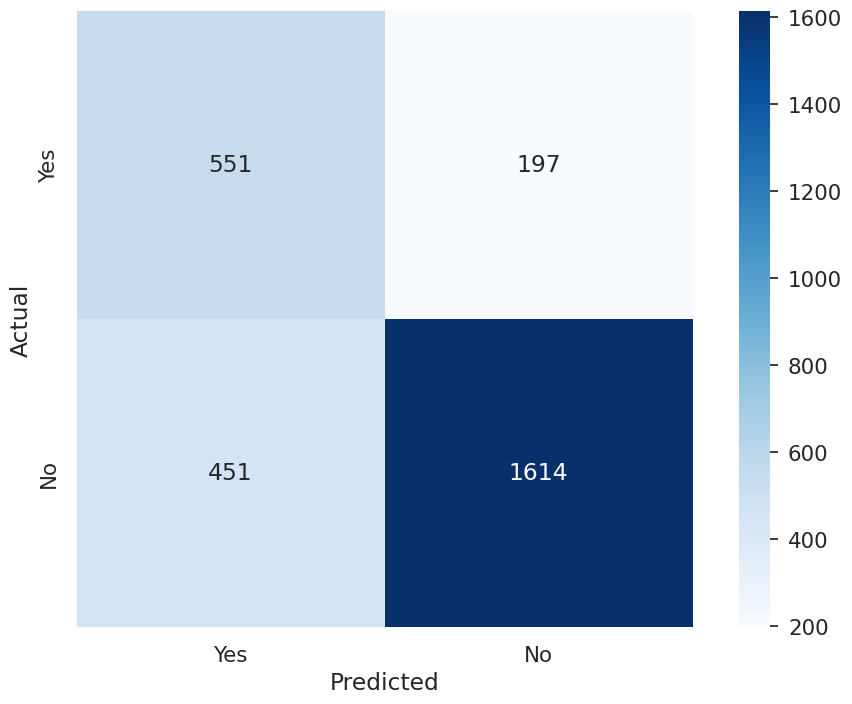

In [ ]:
roc_auc_rs, accuracy_rs, f1_score_rs, threshold_rs = diag_vals(tuned_model)

#### Bayesian optimisation

In [ ]:
tuner_bo = BayesianOptimization(
            hypermodel,
            objective=kt.Objective("val_auc", direction="max"),
            max_trials=20,
            seed=42,
            executions_per_trial=2,
            overwrite=True,
            directory="my_dir",
            project_name="helloworld",
        )

tuner_bo.search(X_train_nn, y_train_nn, epochs=10, validation_data=(X_val_nn, y_val_nn), verbose=1)

best_model_bo = tuner_bo.get_best_models(num_models=1)[0]
best_model_bo.evaluate(X_test, y_test)

Trial 20 Complete [00h 00m 08s]
val_auc: 0.8426128029823303

Best val_auc So Far: 0.8426128029823303
Total elapsed time: 00h 02m 41s
88/88 [==============================] - 0s 1ms/step - loss: 0.4257 - auc: 0.8439


[0.4256846606731415, 0.8438816666603088]

In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)

history_bo = best_model_bo.fit(x = X_train_nn,
                               y = y_train_nn,
                               epochs = 100,
                               verbose = 2,
                               validation_data=(X_val_nn, y_val_nn),
                               callbacks=[checkpoint_cb, early_stopping_cb]
)

Epoch 1/100
132/132 - 1s - loss: 0.4219 - auc: 0.8410 - val_loss: 0.4180 - val_auc: 0.8458 - 929ms/epoch - 7ms/step
Epoch 2/100
132/132 - 0s - loss: 0.4230 - auc: 0.8407 - val_loss: 0.4170 - val_auc: 0.8484 - 218ms/epoch - 2ms/step
Epoch 3/100
132/132 - 0s - loss: 0.4195 - auc: 0.8433 - val_loss: 0.4222 - val_auc: 0.8464 - 300ms/epoch - 2ms/step
Epoch 4/100
132/132 - 0s - loss: 0.4147 - auc: 0.8481 - val_loss: 0.4217 - val_auc: 0.8453 - 298ms/epoch - 2ms/step
Epoch 5/100
132/132 - 0s - loss: 0.4113 - auc: 0.8506 - val_loss: 0.4328 - val_auc: 0.8431 - 236ms/epoch - 2ms/step
Epoch 6/100
132/132 - 0s - loss: 0.4138 - auc: 0.8495 - val_loss: 0.4216 - val_auc: 0.8446 - 222ms/epoch - 2ms/step
Epoch 7/100
132/132 - 0s - loss: 0.4094 - auc: 0.8524 - val_loss: 0.4189 - val_auc: 0.8460 - 289ms/epoch - 2ms/step
Epoch 8/100
132/132 - 0s - loss: 0.4096 - auc: 0.8524 - val_loss: 0.4168 - val_auc: 0.8455 - 232ms/epoch - 2ms/step
Epoch 9/100
132/132 - 0s - loss: 0.4095 - auc: 0.8521 - val_loss: 0.4256

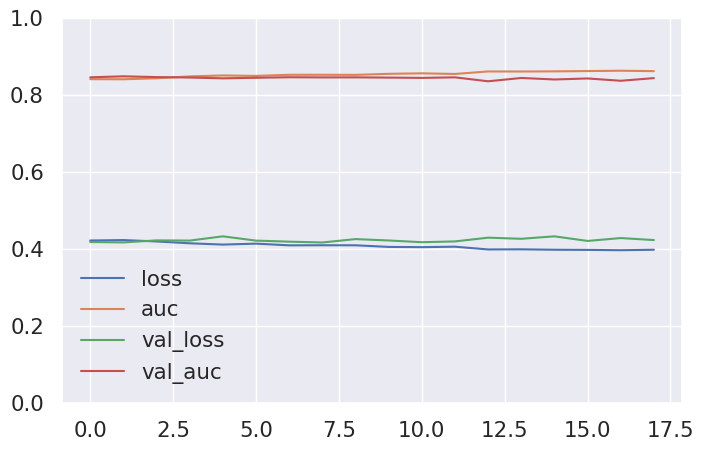

In [ ]:
pd.DataFrame(history_bo.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

ROC/AUC: 0.5
Accuracy: 0.7340917170280838
F1 score: 0.0
132/132 [==============================] - 0s 837us/step


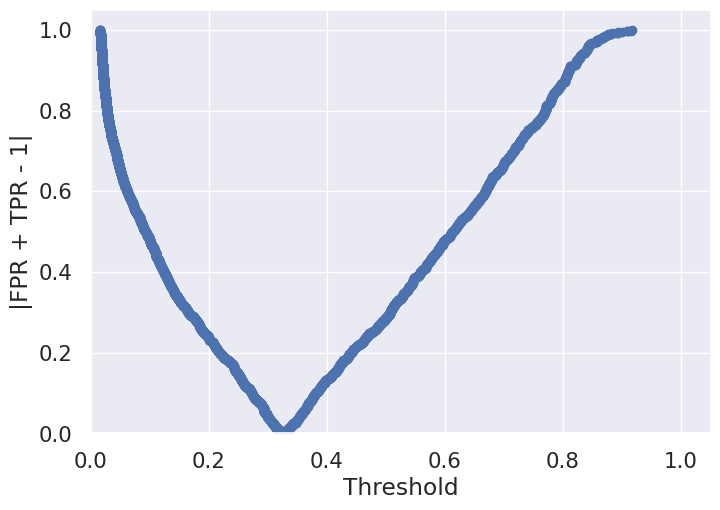

Threshold: 0.32902476
88/88 [==============================] - 0s 826us/step
ROC/AUC threshold: 0.7608570392717952
Accuracy threshold: 0.7753288304301458
F1 score threshold: 0.6334106728538285


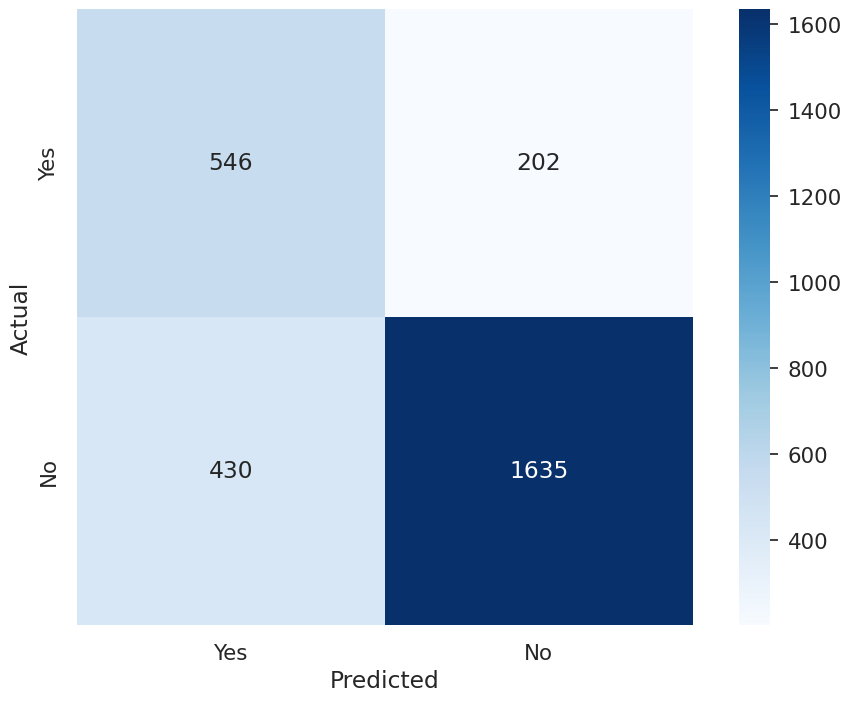

In [ ]:
roc_auc_bo, accuracy_bo, f1_score_bo, threshold_bo = diag_vals(best_model_bo)

#### Hyperband

In [ ]:
tuner_hb = Hyperband(
            hypermodel,
            max_epochs=10,
            objective=kt.Objective("val_auc", direction="max"),
            seed=42,
            executions_per_trial=2,
            overwrite=True,
            directory="my_dir",
            project_name="helloworld",
        )
tuner_hb.search(X_train_nn, y_train_nn, epochs=10, verbose=1, validation_data=(X_val_nn, y_val_nn))
best_model_hb = tuner_hb.get_best_models(num_models=1)[0]
best_model_hb.evaluate(X_test, y_test)

Trial 30 Complete [00h 00m 11s]
val_auc: 0.5186242759227753

Best val_auc So Far: 0.8418959975242615
Total elapsed time: 00h 04m 03s
88/88 [==============================] - 0s 2ms/step - loss: 0.4177 - auc: 0.8442


[0.4177384078502655, 0.8442444801330566]

ROC/AUC: 0.5
Accuracy: 0.7340917170280838
F1 score: 0.0
132/132 [==============================] - 0s 2ms/step


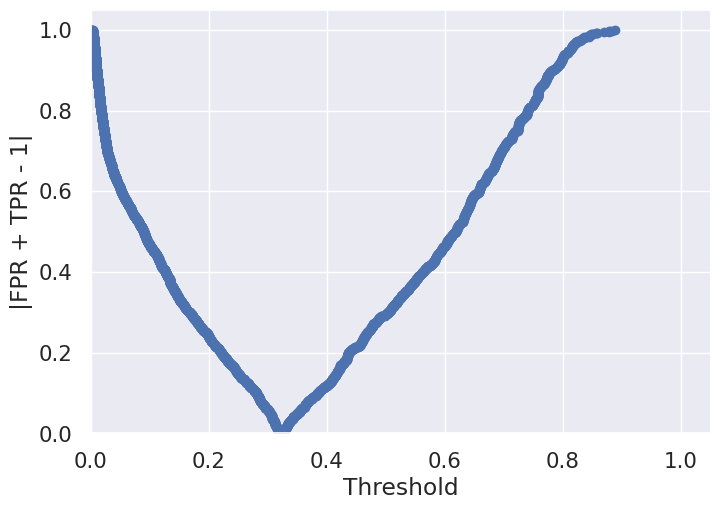

Threshold: 0.3205859
88/88 [==============================] - 0s 1ms/step
ROC/AUC threshold: 0.7613620178425762
Accuracy threshold: 0.7710629221471739
F1 score threshold: 0.6324200913242009


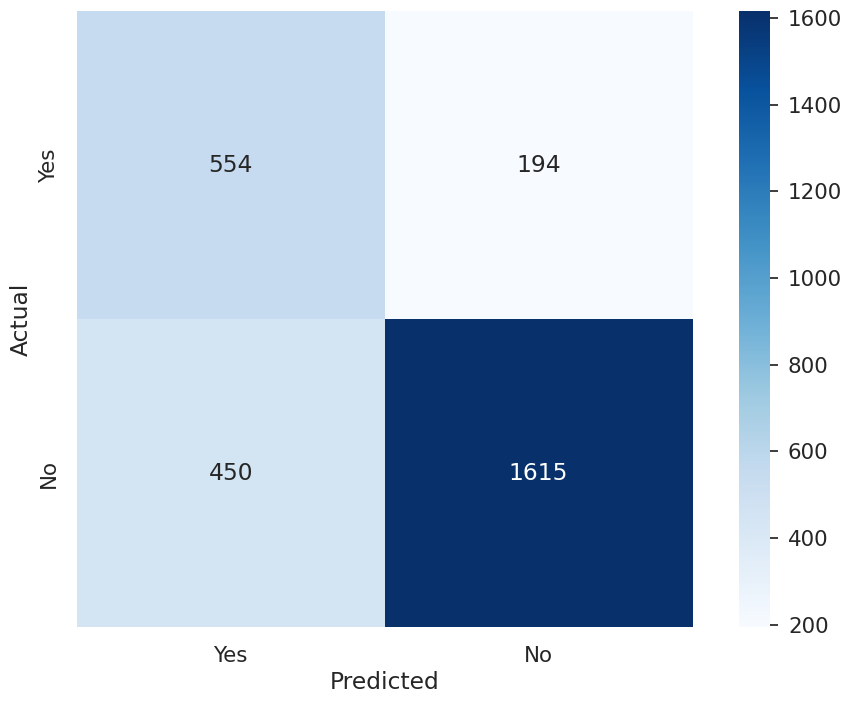

In [ ]:
roc_auc_hb, accuracy_hb, f1_score_hb, threshold_hb = diag_vals(best_model_hb)

#### Batch normalisation model

In [ ]:
from tensorflow.keras.layers import BatchNormalization

bn_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    BatchNormalization(),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dense(20, activation='relu'),
    BatchNormalization(),
    Dense(15, activation='relu'),
    BatchNormalization(),
    Dense(10, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

In [ ]:
bn_model.compile(Adam(learning_rate = 0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint("bn_keras_model.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)

#X_train = np.asarray(X_train_mod).astype(np.float32)
#X_test = np.asarray(X_test_mod).astype(np.float32)

history_bn = bn_model.fit(X_train_nn, y_train_nn,
                          batch_size=25,
                          epochs=100,
                          verbose=2,
                          validation_data=(X_val_nn, y_val_nn),
                          callbacks=[checkpoint_cb, early_stopping_cb])

model_bn = keras.models.load_model("bn_keras_model.h5") # rollback to best model
bn_test = model_bn.evaluate(X_test, y_test)

Epoch 1/100
25/25 - 9s - loss: 0.9918 - accuracy: 0.4588 - val_loss: 0.7313 - val_accuracy: 0.3003 - 9s/epoch - 350ms/step
Epoch 2/100
25/25 - 0s - loss: 0.9330 - accuracy: 0.4766 - val_loss: 0.7442 - val_accuracy: 0.3122 - 346ms/epoch - 14ms/step
Epoch 3/100
25/25 - 0s - loss: 0.9027 - accuracy: 0.4798 - val_loss: 0.7481 - val_accuracy: 0.3356 - 415ms/epoch - 17ms/step
Epoch 4/100
25/25 - 0s - loss: 0.8556 - accuracy: 0.4976 - val_loss: 0.7510 - val_accuracy: 0.3647 - 429ms/epoch - 17ms/step
Epoch 5/100
25/25 - 0s - loss: 0.8000 - accuracy: 0.5186 - val_loss: 0.7531 - val_accuracy: 0.3878 - 409ms/epoch - 16ms/step
Epoch 6/100
25/25 - 0s - loss: 0.8074 - accuracy: 0.5250 - val_loss: 0.7540 - val_accuracy: 0.4058 - 355ms/epoch - 14ms/step
Epoch 7/100
25/25 - 0s - loss: 0.7718 - accuracy: 0.5299 - val_loss: 0.7498 - val_accuracy: 0.4269 - 418ms/epoch - 17ms/step
Epoch 8/100
25/25 - 0s - loss: 0.7722 - accuracy: 0.5363 - val_loss: 0.7456 - val_accuracy: 0.4406 - 417ms/epoch - 17ms/step
Ep

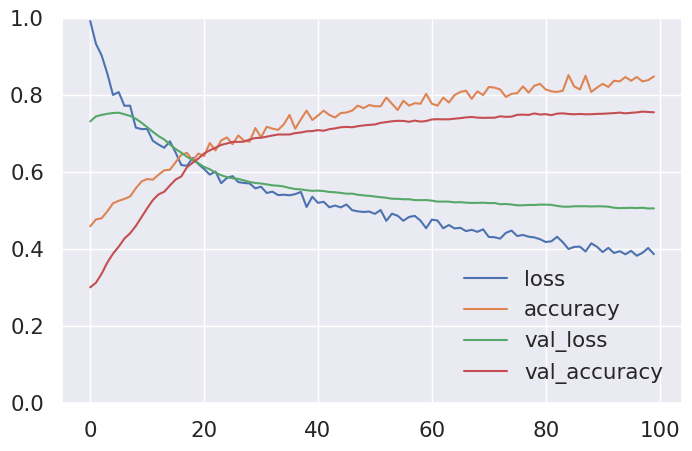

In [ ]:
pd.DataFrame(history_bn.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
nn_model_predictions_bn = model_bn.predict(X_test, batch_size=200, verbose=0)
nn_model_class_predictions_bn = np.argmax(nn_model_predictions_bn, axis=1)

ROC/AUC: 0.5
Accuracy: 0.7340917170280838
F1 score: 0.0
132/132 [==============================] - 1s 3ms/step


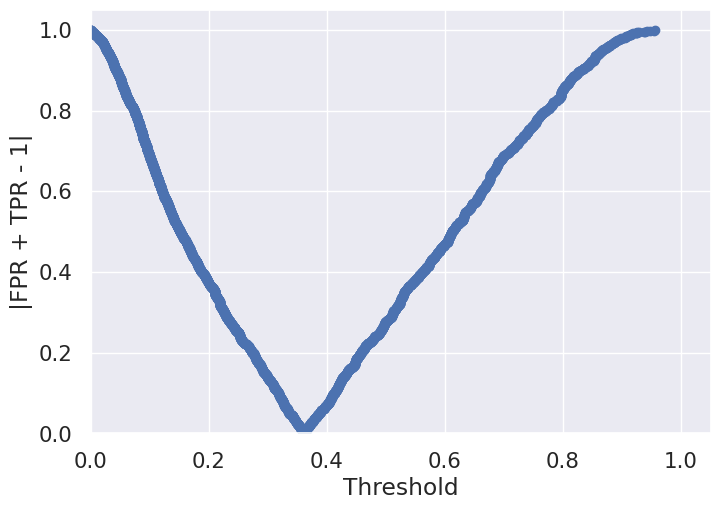

Threshold: 0.36268193
88/88 [==============================] - 0s 3ms/step
ROC/AUC threshold: 0.6854672994004998
Accuracy threshold: 0.7003199431212229
F1 score threshold: 0.5370675453047776


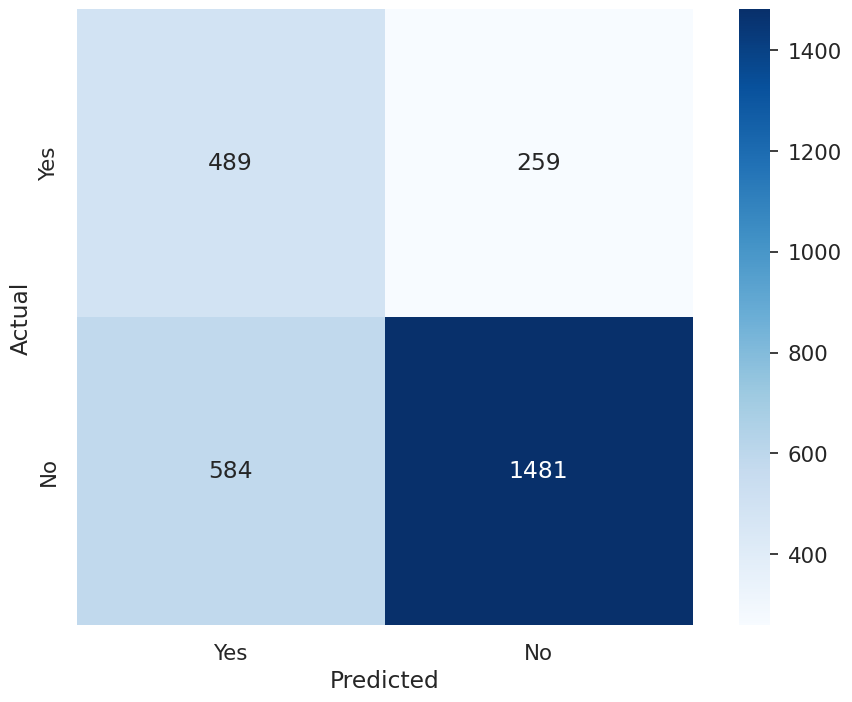

In [ ]:
roc_auc_cb, accuracy_cb, f1_score_cb, threshold_nn = diag_vals(model_bn)

#### Results

In [ ]:
res_vals = pd.DataFrame(['Baseline model', 'Random search model', 'Hyperband model', 'Bayesian optimised model'], columns = ['Model'])
res_vals['ROC-AUC'] = [roc_auc_nn, roc_auc_rs, roc_auc_hb, roc_auc_bo]
res_vals['Accuracy'] = [accuracy_nn, accuracy_rs, accuracy_hb, accuracy_bo]
res_vals['F1-score'] = [f1_score_nn, f1_score_rs, f1_score_hb, f1_score_bo]
res_vals.sort_values(['ROC-AUC'], ascending = False)

,Model,ROC-AUC,Accuracy,F1-score
3,Bayesian optimised model,0.761846,0.771774,0.633143
2,Hyperband model,0.761362,0.771063,0.632420
1,Random search model,0.757536,0.768574,0.627787
0,Baseline model,0.741288,0.765375,0.609929


### Diagnostics

  0%|          | 0/2 [00:00<?, ?it/s]

132/132 [==============================] - 0s 1ms/step
ROC/AUC: 0.7717103607461059
Accuracy: 0.7717468594453663
F1 score: 0.6424062383958411
              precision    recall  f1-score   support

           0       0.90      0.77      0.83      3098
           1       0.55      0.77      0.64      1121

    accuracy                           0.77      4219
   macro avg       0.73      0.77      0.74      4219
weighted avg       0.81      0.77      0.78      4219

[[2391  707]
 [ 256  865]]


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


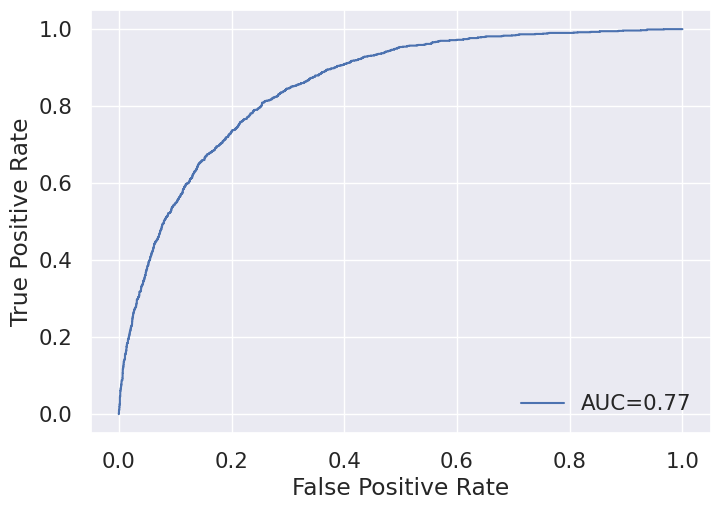

Model: f1 = 0.642 roc_auc = 0.772


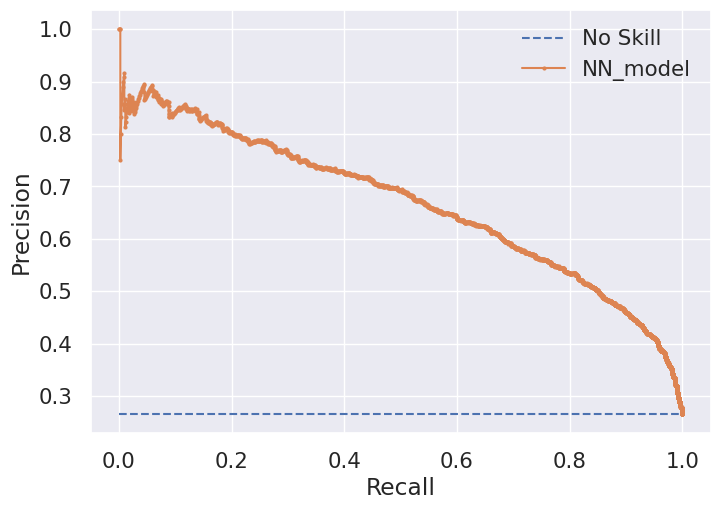


 50%|█████     | 1/2 [00:01<00:01,  1.42s/it]

88/88 [==============================] - 0s 1ms/step
ROC/AUC: 0.7618462793437868
Accuracy: 0.7717739068610024
F1 score: 0.6331428571428571
              precision    recall  f1-score   support

           0       0.89      0.78      0.83      2065
           1       0.55      0.74      0.63       748

    accuracy                           0.77      2813
   macro avg       0.72      0.76      0.73      2813
weighted avg       0.80      0.77      0.78      2813

[[1617  448]
 [ 194  554]]


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


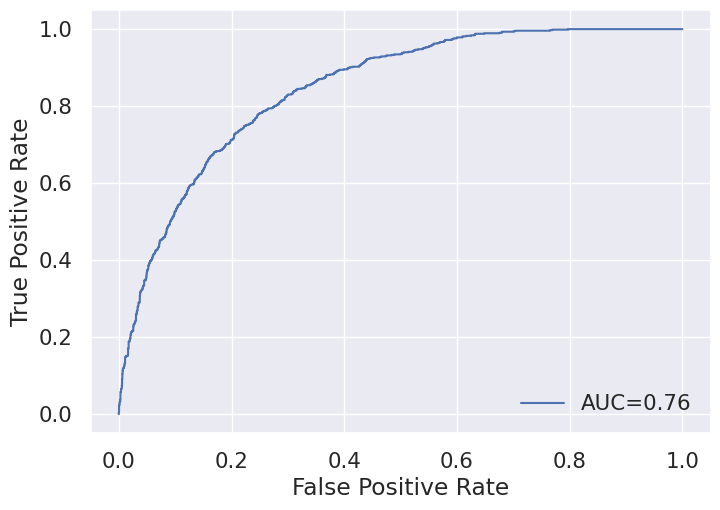

Model: f1 = 0.633 roc_auc = 0.762


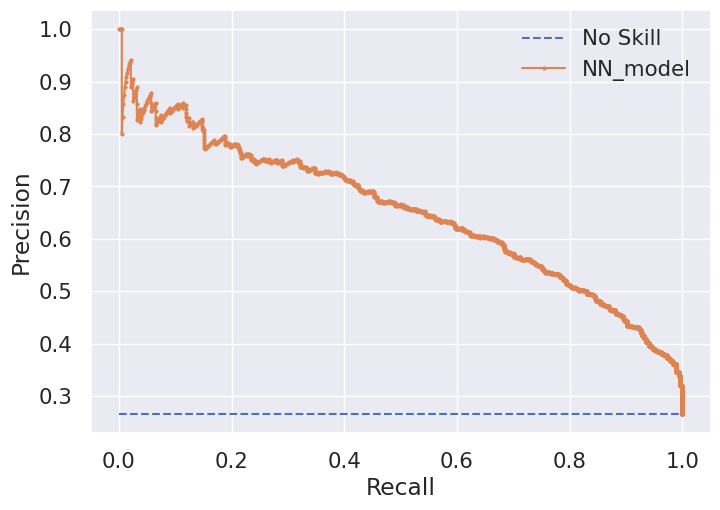


100%|██████████| 1/1 [00:03<00:00,  3.08s/it]


In [ ]:
###########################################
### Assess the performance of the model ###
###########################################

threshold = threshold_bo

#models_optimized = [('CatBoost_optimized', cboost_model_hy),
#                    ('LGBM_optimized', lbgm_model_hy),
#                    ('NN model', nn_model)]

models_optimized = [('NN_model', best_model_bo)]

dset = [('Training', X_train_mod, y_train),
        ('Test', X_test_mod, y_test)]

results_fin = pd.DataFrame(columns = ['Model','Metrics','Training','Test'])

for name, model in tqdm(models_optimized):

    results = pd.DataFrame(['ROC/AUC:','Accuracy:','F1 score:'],
                           columns = ['Metrics'])

    for name_dset, X_dset, y_dset in tqdm(dset):

        #####################
        ### Fit the model ###
        #####################

        if (name != 'LGBM_optimized') & (name != 'NN_model'):

            if name_dset == 'Training':
                model.fit(X_dset, y_dset)

            y_pred_p = model.predict_proba(X_dset)
            y_pred_p1 = y_pred_p[:,1]

        if (name != 'NN_model'):
            y_pred_hyp = model.predict(X_dset)

        if name == 'LGBM_optimized':
            y_pred_p1 = pd.DataFrame(y_pred_hyp)
            y_pred_hyp = np.rint(y_pred_hyp)

        elif name == 'NN_model':
            y_pred_p1 = model.predict(X_dset)
            y_pred_hyp = (model.predict(X_dset) >= threshold)[:,0]

        metric = []
        roc_auc_hyp = roc_auc_score(y_dset, y_pred_hyp)
        metric.append(roc_auc_hyp)
        accuracy_hyp = accuracy_score(y_dset, y_pred_hyp)
        metric.append(accuracy_hyp)
        f1_score_hyp = metrics.f1_score(y_dset, y_pred_hyp)
        metric.append(f1_score_hyp)

        print('ROC/AUC:', roc_auc_hyp)
        print('Accuracy:', accuracy_hyp)
        print('F1 score:', f1_score_hyp)

        print(classification_report(y_dset, y_pred_hyp))

        from sklearn.metrics import confusion_matrix
        cm = confusion_matrix(y_dset, y_pred_hyp)

        cm_as_df = cm2df(cm,['Not churn','Churn'])

        print(confusion_matrix(y_dset, y_pred_hyp))

        results = pd.concat([results,
                             pd.DataFrame(metric,
                                          columns = [name_dset])],
                            axis = 1)

        #################
        ### ROC curve ###
        #################

        fpr, tpr, _ = metrics.roc_curve(y_dset,  y_pred_p1)

        plt.plot(fpr,
                 tpr,
                 label = "AUC=" + str(round(roc_auc_hyp,2)))
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.legend(loc=4)
        plt.show()

        roc_data = pd.concat([pd.DataFrame(fpr),
                              pd.DataFrame(tpr)],axis = 1)
        roc_data.columns = ['FPR','TPR']
        roc_data = roc_data.reset_index()

        ###############################
        ### Precision Recall curves ###
        ###############################

        precision, recall, thresholds = precision_recall_curve(y_dset,
                                                               y_pred_p1)

        ### calculate F1 score ###

        f1 = metrics.f1_score(y_dset, y_pred_hyp)

        ### summarize scores ###

        print('Model: f1 = %.3f roc_auc = %.3f' % (f1, roc_auc_hyp))

        ### plot the precision-recall curves ###

        no_skill = len(y_dset[y_dset == 1]) / len(y_dset)

        plt.plot([0, 1],
                 [no_skill, no_skill],
                 linestyle='--',
                 label='No Skill')
        plt.plot(recall,
                 precision,
                 marker='.',
                 label = name)
        plt.xlabel('Recall')
        plt.ylabel('Precision')

        ### show the legend ###
        plt.legend()
        plt.show()

        pr_data = pd.concat([pd.DataFrame(precision),
                              pd.DataFrame(recall)],axis = 1)
        pr_data.columns = ['Precision','Recall']
        pr_data = pr_data.reset_index()

        results['Model'] = name

    results_fin = pd.concat([results_fin,
                             results],
                            axis = 0)

### Shapley values

In [ ]:
explainer = shap.TreeExplainer(lbgm_model_hy)
shap_values = explainer.shap_values(X_train_mod)

# visualize the first prediction's explanation
shap.initjs()

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


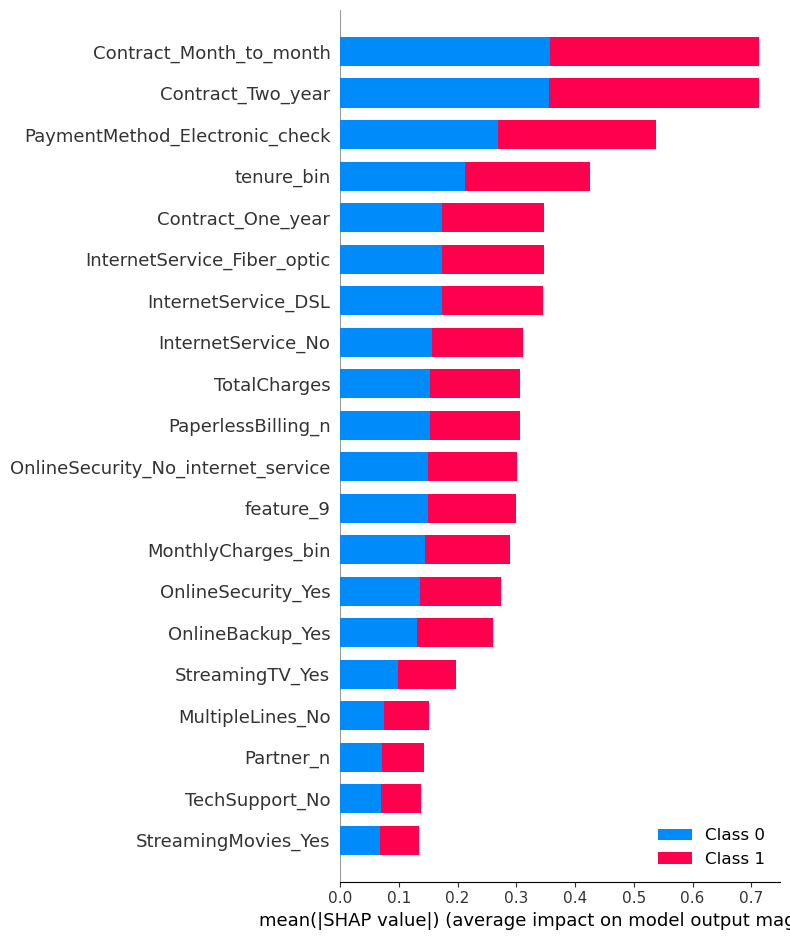

In [ ]:
shap_values = shap.TreeExplainer(lbgm_model_hy).shap_values(X_train_mod)
shap.summary_plot(shap_values, X_train_mod, plot_type="bar");

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


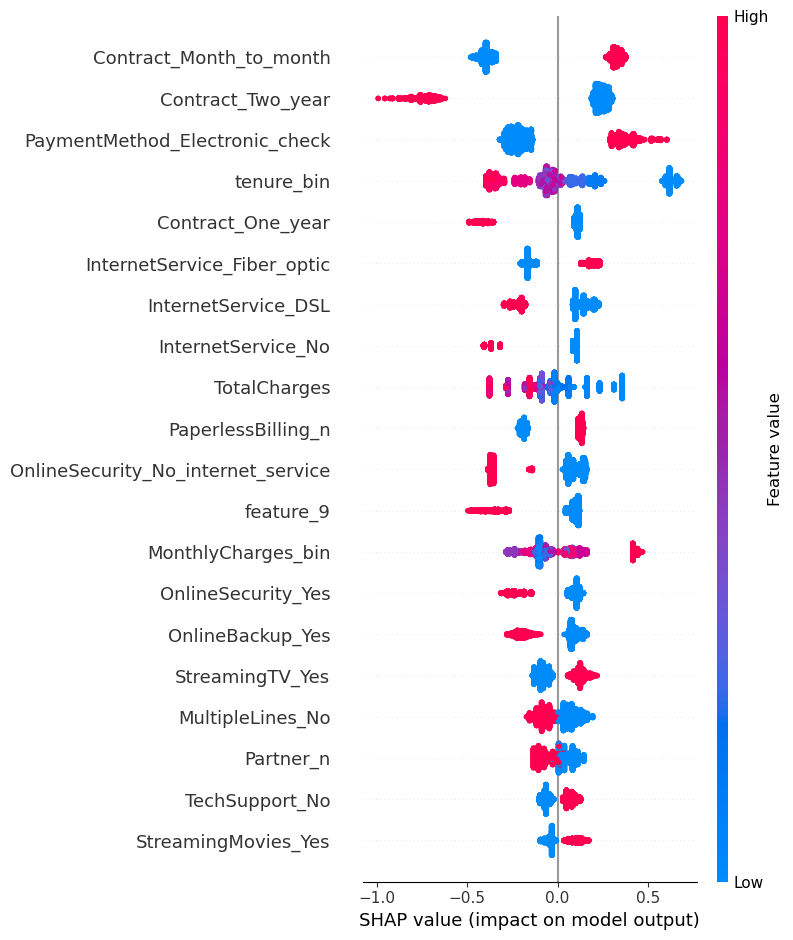

In [ ]:
shap.summary_plot(shap_values[1], X_train_mod, plot_type='dot')